As my last assignment from Sport Data Analytics course I would like to choose the GUST_boxing_classification dataset to apply several machine learning classification models on it. As in the article[1] of this source was mentioned, I would use the whole data as sensor configuration 2, where the user not only weares sensor on third thoracic vertebrae, but also on both wrists in a special pair of gloves to detect box punches. This way we can classify types of strikes.

Worsey, Matthew T.O.; Espinosa, Hugo G.; Shepherd, Jonathan B.; Thiel, David V. 2020. "An Evaluation of Wearable Inertial Sensor Configuration and Supervised Machine Learning Models for Automatic Punch Classification in Boxing" IoT 1, no. 2: 360-381. https://doi.org/10.3390/iot1020021

In [1]:
#include all packages that will be needed
import pandas as pd
import numpy as np
import zipfile
import warnings
from scipy.signal import find_peaks

warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier, plot_tree
from mlxtend.plotting import plot_decision_regions
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# I am using raw data file as I can be sure there are all three sensors' data:
filename="gust_boxing.zip"
df_raw_left=pd.read_excel(zipfile.ZipFile(filename).open("GUST_boxing_classification_data/Raw_sensor_training_data.xlsx"),sheet_name="Left wrist")
df_raw_right=pd.read_excel(zipfile.ZipFile(filename).open("GUST_boxing_classification_data/Raw_sensor_training_data.xlsx"),sheet_name="Right wrist")
df_raw_t3=pd.read_excel(zipfile.ZipFile(filename).open("GUST_boxing_classification_data/Raw_sensor_training_data.xlsx"),sheet_name="Upper back (T3)")

In [ ]:
df_raw_left.drop('Sample_rate (Hz)', axis='columns', inplace=True)
df_raw_left.dropna()
df_raw_right.drop('Sample_rate (Hz)', axis='columns', inplace=True)
df_raw_right.dropna()
df_raw_left.head()

,Accel_x (g),Accel_y (g),Accel_z (g),Gyro_x (deg/s),Gyro_y (deg/s,Gyro_z (deg/s,Roll (rad),Pitch (rad),Yaw (rad)
0,0.902832,-0.353027,-0.229492,-1.341463,-2.865854,0.670732,-0.010407,-0.016146,-0.006142
1,0.902832,-0.356445,-0.238770,-1.646341,-2.926829,0.548780,-0.020827,-0.032318,-0.012059
2,0.897949,-0.353027,-0.235352,-1.524390,-2.865854,0.792683,-0.028291,-0.047797,-0.022268
3,0.900391,-0.350098,-0.231934,-1.646341,-2.926829,1.097561,-0.035675,-0.063366,-0.032244
4,0.900879,-0.350098,-0.233398,-1.524390,-2.926829,0.853659,-0.043032,-0.078995,-0.041999


In [ ]:
print(len(df_raw_t3))
df_raw_t3.drop('Sample_rate (Hz)', axis='columns', inplace=True)
df_raw_t3.dropna()
df_raw_t3.head()

167935


,Accel_x (g),Accel_y (g),Accel_z (g),Gyro_x (deg/s),Gyro_y (deg/s,Gyro_z (deg/s,Roll (rad),Pitch (rad),Yaw (rad)
0,-0.914062,0.107422,-0.455566,-0.914062,0.107422,-0.455566,-1.768293,0.365854,-0.914634
1,-0.919434,0.101562,-0.461426,-0.919434,0.101562,-0.461426,-2.012195,0.304878,-0.792683
2,-0.911133,0.106934,-0.454590,-0.911133,0.106934,-0.454590,-1.951220,0.243902,-0.609756
3,-0.923828,0.103516,-0.445801,-0.923828,0.103516,-0.445801,-1.951220,0.243902,-0.731707
4,-0.914062,0.105957,-0.454102,-0.914062,0.105957,-0.454102,-2.195122,0.304878,-0.792683


In [ ]:
# 1: it seems only the first 250 punches were observed and labeled, so I need to cut data there
# 2: I need more features as in the other prepared data files
# 3: need to merge all 4 datasets
# 4: need to take only the 'Training_session' column as y
# 5: I already do not care about Sample_rate column, and needed to drop from all 3 input data


def calc_features(df_raw):
  list_of_features = list()
  for i in range(250):
    features={}
    start = i*300
    end =((i+1)*300)-1
    features["Ax_mean"]=df_raw["Accel_x (g)"].iloc[start:end].mean()
    features["Ax_std"]=df_raw["Accel_x (g)"].iloc[start:end].std()
    features["Ax_min"]=df_raw["Accel_x (g)"].iloc[start:end].min()
    features["Ax_minpos"]=df_raw["Accel_x (g)"].iloc[start:end].idxmin()
    features["Ax_max"]=df_raw["Accel_x (g)"].iloc[start:end].max()
    features["Ax_maxpos"]=df_raw["Accel_x (g)"].iloc[start:end].idxmax()
    features["Ax_kurtosis"]=df_raw["Accel_x (g)"].iloc[start:end].kurtosis()
    features["Ax_skew"]=df_raw["Accel_x (g)"].iloc[start:end].skew()
    features["Ax_diff"]=features["Ax_max"] - features["Ax_min"]
    features["Ax_energy"]=(df_raw["Accel_x (g)"].iloc[start:end]**2).sum()/300
    features["Ax_num_peaks"]=len(find_peaks(df_raw["Accel_x (g)"].iloc[start:end])[0])

    features["Ay_mean"]=df_raw["Accel_y (g)"].iloc[start:end].mean()
    features["Ay_std"]=df_raw["Accel_y (g)"].iloc[start:end].std()
    features["Ay_min"]=df_raw["Accel_y (g)"].iloc[start:end].min()
    features["Ay_minpos"]=df_raw["Accel_y (g)"].iloc[start:end].idxmin()
    features["Ay_max"]=df_raw["Accel_y (g)"].iloc[start:end].max()
    features["Ay_maxpos"]=df_raw["Accel_y (g)"].iloc[start:end].idxmax()
    features["Ay_kurtosis"]=df_raw["Accel_y (g)"].iloc[start:end].kurtosis()
    features["Ay_skew"]=df_raw["Accel_y (g)"].iloc[start:end].skew()
    features["Ay_diff"]=features["Ay_max"] - features["Ay_min"]
    features["Ay_energy"]=(df_raw["Accel_y (g)"].iloc[start:end]**2).sum()/300
    features["Ay_num_peaks"]=len(find_peaks(df_raw["Accel_y (g)"].iloc[start:end])[0])

    features["Az_mean"]=df_raw["Accel_z (g)"].iloc[start:end].mean()
    features["Az_std"]=df_raw["Accel_z (g)"].iloc[start:end].std()
    features["Az_min"]=df_raw["Accel_z (g)"].iloc[start:end].min()
    features["Az_minpos"]=df_raw["Accel_z (g)"].iloc[start:end].idxmin()
    features["Az_max"]=df_raw["Accel_z (g)"].iloc[start:end].max()
    features["Az_maxpos"]=df_raw["Accel_z (g)"].iloc[start:end].idxmax()
    features["Az_kurtosis"]=df_raw["Accel_z (g)"].iloc[start:end].kurtosis()
    features["Az_skew"]=df_raw["Accel_z (g)"].iloc[start:end].skew()
    features["Az_diff"]=features["Az_max"] - features["Az_min"]
    features["Az_energy"]=(df_raw["Accel_z (g)"].iloc[start:end]**2).sum()/300
    features["Az_num_peaks"]=len(find_peaks(df_raw["Accel_z (g)"].iloc[start:end])[0])

    features['Acc_vectorial_sum']=((df_raw["Accel_x (g)"].iloc[start:end]**2 + df_raw["Accel_y (g)"].iloc[start:end]**2 + df_raw["Accel_z (g)"].iloc[start:end]**2)**0.5).mean()
    features['Acc_magnitude']=(df_raw["Accel_x (g)"].iloc[start:end].abs()/100).sum() + (df_raw["Accel_y (g)"].iloc[start:end].abs()/100).sum() + (df_raw["Accel_z (g)"].iloc[start:end].abs()/100).sum()

    features["Gx_mean"]=df_raw["Gyro_x (deg/s)"].iloc[start:end].mean()
    features["Gx_std"]=df_raw["Gyro_x (deg/s)"].iloc[start:end].std()
    features["Gx_min"]=df_raw["Gyro_x (deg/s)"].iloc[start:end].min()
    features["Gx_minpos"]=df_raw["Gyro_x (deg/s)"].iloc[start:end].idxmin()
    features["Gx_max"]=df_raw["Gyro_x (deg/s)"].iloc[start:end].max()
    features["Gx_maxpos"]=df_raw["Gyro_x (deg/s)"].iloc[start:end].idxmax()
    features["Gx_kurtosis"]=df_raw["Gyro_x (deg/s)"].iloc[start:end].kurtosis()
    features["Gx_skew"]=df_raw["Gyro_x (deg/s)"].iloc[start:end].skew()
    features["Gx_diff"]=features["Gx_max"] - features["Gx_min"]
    features["Gx_energy"]=(df_raw["Gyro_x (deg/s)"].iloc[start:end]**2).sum()/300
    features["Gx_num_peaks"]=len(find_peaks(df_raw["Gyro_x (deg/s)"].iloc[start:end])[0])

    features["Gy_mean"]=df_raw["Gyro_y (deg/s"].iloc[start:end].mean()
    features["Gy_std"]=df_raw["Gyro_y (deg/s"].iloc[start:end].std()
    features["Gy_min"]=df_raw["Gyro_y (deg/s"].iloc[start:end].min()
    features["Gy_minpos"]=df_raw["Gyro_y (deg/s"].iloc[start:end].idxmin()
    features["Gy_max"]=df_raw["Gyro_y (deg/s"].iloc[start:end].max()
    features["Gy_maxpos"]=df_raw["Gyro_y (deg/s"].iloc[start:end].idxmax()
    features["Gy_kurtosis"]=df_raw["Gyro_y (deg/s"].iloc[start:end].kurtosis()
    features["Gy_skew"]=df_raw["Gyro_y (deg/s"].iloc[start:end].skew()
    features["Gy_diff"]=features["Gy_max"] - features["Gy_min"]
    features["Gy_energy"]=(df_raw["Gyro_y (deg/s"].iloc[start:end]**2).sum()/300
    features["Gy_num_peaks"]=len(find_peaks(df_raw["Gyro_y (deg/s"].iloc[start:end])[0])

    features["Gz_mean"]=df_raw["Gyro_z (deg/s"].iloc[start:end].mean()
    features["Gz_std"]=df_raw["Gyro_z (deg/s"].iloc[start:end].std()
    features["Gz_min"]=df_raw["Gyro_z (deg/s"].iloc[start:end].min()
    features["Gz_minpos"]=df_raw["Gyro_z (deg/s"].iloc[start:end].idxmin()
    features["Gz_max"]=df_raw["Gyro_z (deg/s"].iloc[start:end].max()
    features["Gz_maxpos"]=df_raw["Gyro_z (deg/s"].iloc[start:end].idxmax()
    features["Gz_kurtosis"]=df_raw["Gyro_z (deg/s"].iloc[start:end].kurtosis()
    features["Gz_skew"]=df_raw["Gyro_z (deg/s"].iloc[start:end].skew()
    features["Gz_diff"]=features["Gz_max"] - features["Gz_min"]
    features["Gz_energy"]=(df_raw["Gyro_z (deg/s"].iloc[start:end]**2).sum()/300
    features["Gz_num_peaks"]=len(find_peaks(df_raw["Gyro_z (deg/s"].iloc[start:end])[0])

    features['Gyro_vectorial_sum']=((df_raw["Gyro_x (deg/s)"].iloc[start:end]**2 + df_raw["Gyro_y (deg/s"].iloc[start:end]**2 + df_raw["Gyro_z (deg/s"].iloc[start:end]**2)**0.5).mean()
    features['Gyro_magnitude']=(df_raw["Gyro_x (deg/s)"].iloc[start:end].abs()/100).sum() + (df_raw["Gyro_y (deg/s"].iloc[start:end].abs()/100).sum() + (df_raw["Gyro_z (deg/s"].iloc[start:end].abs()/100).sum()

    features["Roll_mean"]=df_raw["Roll (rad)"].iloc[start:end].mean()
    features["Roll_std"]=df_raw["Roll (rad)"].iloc[start:end].std()
    features["Roll_min"]=df_raw["Roll (rad)"].iloc[start:end].min()
    features["Roll_minpos"]=df_raw["Roll (rad)"].iloc[start:end].idxmin()
    features["Roll_max"]=df_raw["Roll (rad)"].iloc[start:end].max()
    features["Roll_maxpos"]=df_raw["Roll (rad)"].iloc[start:end].idxmax()
    features["Roll_kurtosis"]=df_raw["Roll (rad)"].iloc[start:end].kurtosis()
    features["Roll_skew"]=df_raw["Roll (rad)"].iloc[start:end].skew()
    features["Roll_diff"]=features["Roll_max"] - features["Roll_min"]
    features["Roll_energy"]=(df_raw["Roll (rad)"].iloc[start:end]**2).sum()/300
    features["Roll_num_peaks"]=len(find_peaks(df_raw["Roll (rad)"].iloc[start:end])[0])

    features["Pitch_mean"]=df_raw["Pitch (rad)"].iloc[start:end].mean()
    features["Pitch_std"]=df_raw["Pitch (rad)"].iloc[start:end].std()
    features["Pitch_min"]=df_raw["Pitch (rad)"].iloc[start:end].min()
    features["Pitch_minpos"]=df_raw["Pitch (rad)"].iloc[start:end].idxmin()
    features["Pitch_max"]=df_raw["Pitch (rad)"].iloc[start:end].max()
    features["Pitch_maxpos"]=df_raw["Pitch (rad)"].iloc[start:end].idxmax()
    features["Pitch_kurtosis"]=df_raw["Pitch (rad)"].iloc[start:end].kurtosis()
    features["Pitch_skew"]=df_raw["Pitch (rad)"].iloc[start:end].skew()
    features["Pitch_diff"]=features["Pitch_max"] - features["Pitch_min"]
    features["Pitch_energy"]=(df_raw["Pitch (rad)"].iloc[start:end]**2).sum()/300
    features["Pitch_num_peaks"]=len(find_peaks(df_raw["Pitch (rad)"].iloc[start:end])[0])

    features["Yaw_mean"]=df_raw["Yaw (rad)"].iloc[start:end].mean()
    features["Yaw_std"]=df_raw["Yaw (rad)"].iloc[start:end].std()
    features["Yaw_min"]=df_raw["Yaw (rad)"].iloc[start:end].min()
    features["Yaw_minpos"]=df_raw["Yaw (rad)"].iloc[start:end].idxmin()
    features["Yaw_max"]=df_raw["Yaw (rad)"].iloc[start:end].max()
    features["Yaw_maxpos"]=df_raw["Yaw (rad)"].iloc[start:end].idxmax()
    features["Yaw_kurtosis"]=df_raw["Yaw (rad)"].iloc[start:end].kurtosis()
    features["Yaw_skew"]=df_raw["Yaw (rad)"].iloc[start:end].skew()
    features["Yaw_diff"]=features["Yaw_max"] - features["Yaw_min"]
    features["Yaw_energy"]=(df_raw["Yaw (rad)"].iloc[start:end]**2).sum()/300
    features["Yaw_num_peaks"]=len(find_peaks(df_raw["Yaw (rad)"].iloc[start:end])[0])

    features['motion_vectorial_sum']=((df_raw["Roll (rad)"].iloc[start:end]**2 + df_raw["Pitch (rad)"].iloc[start:end]**2 + df_raw["Yaw (rad)"].iloc[start:end]**2)**0.5).mean()
    features['motion_magnitude']=(df_raw["Roll (rad)"].iloc[start:end].abs()/100).sum() + (df_raw["Pitch (rad)"].iloc[start:end].abs()/100).sum() + (df_raw["Yaw (rad)"].iloc[start:end].abs()/100).sum()

    list_of_features.append(features)
  instances = pd.DataFrame(list_of_features)
  return instances


f1 = calc_features(df_raw_left)
f2 = calc_features(df_raw_right)
f3 = calc_features(df_raw_t3)
#f1.to_csv('/content/drive/MyDrive/Data analytics in sport and rehabilitation/featuresLeft.csv')
#f2.to_csv('/content/drive/MyDrive/Data analytics in sport and rehabilitation/featuresRight.csv')
#f3.to_csv('/content/drive/MyDrive/Data analytics in sport and rehabilitation/featuresT3.csv')
f1

,Ax_mean,Ax_std,Ax_min,Ax_minpos,Ax_max,Ax_maxpos,Ax_kurtosis,Ax_skew,Ax_diff,Ax_energy,...,Yaw_minpos,Yaw_max,Yaw_maxpos,Yaw_kurtosis,Yaw_skew,Yaw_diff,Yaw_energy,Yaw_num_peaks,motion_vectorial_sum,motion_magnitude
0,0.808221,0.197954,0.196777,298,0.971680,203,2.439069,-1.941614,0.774902,0.689969,...,49,0.643235,137,-1.076220,-0.742528,0.902390,0.189189,54,1.830191,8.199158
1,0.345130,0.084746,0.188477,302,0.510254,497,-1.081262,-0.079611,0.321777,0.125852,...,456,0.435077,598,-0.674729,0.624037,0.202496,0.095571,0,1.843719,6.779167
2,0.690021,0.225914,0.247070,608,0.912598,772,-1.072459,-0.702378,0.665527,0.525240,...,750,0.440653,609,-1.006480,0.142493,0.241310,0.101215,1,1.879948,8.258127
3,0.898256,0.008278,0.863770,901,0.916992,1133,3.304826,-1.398078,0.053223,0.804243,...,1198,0.400929,936,0.551185,-0.981890,0.042217,0.149771,20,2.305524,10.408682
4,0.844322,0.078760,0.694336,1417,0.949219,1361,-1.314814,-0.475445,0.254883,0.716664,...,1498,0.357429,1200,-1.431235,-0.544958,0.262333,0.069448,1,2.239066,9.704374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,-0.763709,0.688646,-2.469238,73797,1.437500,73500,2.401738,0.978220,3.906738,1.052380,...,73515,1.750042,73788,-0.802072,0.360224,2.356867,0.682532,2,3.101473,12.954871
246,-0.126819,2.423823,-4.838379,73836,15.999512,73850,8.138734,1.637033,20.837891,5.851782,...,73920,2.222206,74098,-1.257087,0.201329,2.880564,1.121163,1,2.801166,11.247592
247,-0.268906,2.533593,-5.114746,74229,14.752441,74249,6.568804,1.760352,19.867188,6.448368,...,74309,2.368485,74126,-1.710987,0.143015,3.004333,1.950581,3,2.995931,12.797160
248,-0.629231,2.512281,-5.095703,74627,15.999512,74644,8.064151,1.964692,21.095215,6.664088,...,74698,1.872388,74588,-1.286227,0.466999,2.496815,0.893812,1,3.415186,13.941736


In [ ]:
#f1 = pd.read_csv("/content/drive/MyDrive/Data analytics in sport and rehabilitation/featuresLeft.csv")
#f2 = pd.read_csv("/content/drive/MyDrive/Data analytics in sport and rehabilitation/featuresRight.csv")
#f3 = pd.read_csv("/content/drive/MyDrive/Data analytics in sport and rehabilitation/featuresT3.csv")

In [ ]:
joined1 = pd.merge(f1, f2, left_index=True, right_index=True)
inputData = pd.merge(joined1, f3, left_index=True, right_index=True)
inputData = inputData.dropna()

#inputData

In [ ]:
#if needed:
#inputData=inputData.drop(inputData.columns[[0]],axis = 1)
#inputData.drop(columns=['Unnamed: 0_y', 'Unnamed: 0'], inplace=True)

In [ ]:
#inputData.to_csv('/content/drive/MyDrive/Data analytics in sport and rehabilitation/box_inputs.csv')
inputData.head()

,Ax_mean_x,Ax_std_x,Ax_min_x,Ax_minpos_x,Ax_max_x,Ax_maxpos_x,Ax_kurtosis_x,Ax_skew_x,Ax_diff_x,Ax_energy_x,...,Yaw_minpos,Yaw_max,Yaw_maxpos,Yaw_kurtosis,Yaw_skew,Yaw_diff,Yaw_energy,Yaw_num_peaks,motion_vectorial_sum,motion_magnitude
0,0.808221,0.197954,0.196777,298,0.971680,203,2.439069,-1.941614,0.774902,0.689969,...,258,-0.121951,119,-0.787140,-1.014239,16.036585,55.456115,68,5.833410,25.752439
1,0.345130,0.084746,0.188477,302,0.510254,497,-1.081262,-0.079611,0.321777,0.125852,...,300,9.451220,371,-0.364939,0.021367,21.768293,22.853857,31,29.376861,105.767073
2,0.690021,0.225914,0.247070,608,0.912598,772,-1.072459,-0.702378,0.665527,0.525240,...,614,12.317073,750,-1.241900,0.282560,16.768293,36.870067,41,11.588186,51.326829
3,0.898256,0.008278,0.863770,901,0.916992,1133,3.304826,-1.398078,0.053223,0.804243,...,902,13.658537,1093,-0.842269,-0.488987,15.975610,79.404781,48,10.613726,48.407317
4,0.844322,0.078760,0.694336,1417,0.949219,1361,-1.314814,-0.475445,0.254883,0.716664,...,1379,4.329268,1203,0.597660,1.233336,9.390244,7.885708,69,6.795107,31.298171


In [ ]:
# get the labels for supervised machine learning: classes for classification
filename="gust_boxing.zip"

df_y=pd.read_excel(zipfile.ZipFile(filename).open("GUST_boxing_classification_data/Punch_orders_video_analysis.xlsx"))
print(df_y.head())

df_y.drop('Evaluation_session', axis='columns', inplace=True)
#df_y.to_csv('/content/drive/MyDrive/Data analytics in sport and rehabilitation/box_outputs.csv')
#df_y = pd.read_csv('/content/drive/MyDrive/Data analytics in sport and rehabilitation/box_outputs.csv')
df_y

  Training_session Evaluation_session
0         Left_jab        Right Cross
1         Left_jab           Left Jab
2         Left_jab           Left Jab
3         Left_jab    Right Upper Cut
4         Left_jab          Left Hook


,Training_session
0,Left_jab
1,Left_jab
2,Left_jab
3,Left_jab
4,Left_jab
...,...
245,Right_uppercut
246,Right_uppercut
247,Right_uppercut
248,Right_uppercut


In [ ]:
#need to split dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(inputData, df_y, test_size=0.2, random_state=42)

In [ ]:
# save dataFrames so later it is easy to use
#X_train.to_csv('/content/drive/MyDrive/Data analytics in sport and rehabilitation/X_train.csv')
#X_test.to_csv('/content/drive/MyDrive/Data analytics in sport and rehabilitation/X_test.csv')
#y_train.to_csv('/content/drive/MyDrive/Data analytics in sport and rehabilitation/y_train.csv')
#y_test.to_csv('/content/drive/MyDrive/Data analytics in sport and rehabilitation/y_test.csv')

In [ ]:
X_test.head()

,Ax_mean_x,Ax_std_x,Ax_min_x,Ax_minpos_x,Ax_max_x,Ax_maxpos_x,Ax_kurtosis_x,Ax_skew_x,Ax_diff_x,Ax_energy_x,...,Yaw_minpos,Yaw_max,Yaw_maxpos,Yaw_kurtosis,Yaw_skew,Yaw_diff,Yaw_energy,Yaw_num_peaks,motion_vectorial_sum,motion_magnitude
142,0.811097,0.005880,0.795410,42726,0.825195,42608,-0.531333,-0.064891,0.029785,0.655720,...,42802,0.243902,42639,-0.378168,0.428897,1.341463,0.323369,83,2.348618,10.498780
6,0.772144,0.049957,0.651855,2098,0.865723,1906,-1.281463,0.001131,0.213867,0.596698,...,2062,-1.097561,1978,0.045733,-1.302622,19.512195,82.294244,52,22.480950,102.279878
97,-0.612328,1.615978,-4.654785,29240,15.999512,29233,43.625543,4.938877,20.654297,2.967672,...,29398,98.292683,29227,-0.285382,0.597865,148.475610,1247.511464,30,57.028888,250.779878
60,-0.648790,1.972946,-5.562012,18235,15.999512,18229,23.988881,3.966464,21.561523,4.286092,...,18018,135.670732,18236,0.483341,1.108570,196.158537,1889.440400,23,58.836858,251.751220
112,0.196315,0.122277,-0.122559,33648,0.453125,33756,-0.963957,0.529975,0.575684,0.053263,...,33745,13.658537,33864,-0.979764,-0.614954,73.963415,690.402860,19,29.386621,133.264024


# Now I would start machine learning with Logistic regression, with 10-fold cross validation
Then check accuracy and confusion matrix

results: [0.65 0.65 0.65 0.75 0.55 0.45 0.4  0.65 0.65 0.6 ]
mean score: 0.6
standardd deviation: 0.09999999999999999
accuracy = 0.56


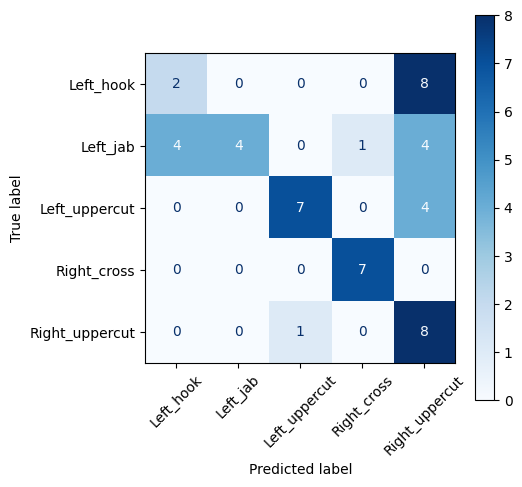

In [ ]:
reg_model = LogisticRegression()
results=cross_validate(reg_model,X_train,y_train,cv=10,scoring='accuracy')

# check the results:
print("results:", results['test_score'])
print("mean score:", np.mean(results['test_score']))
print("standardd deviation:", np.std(results['test_score']))

# now I fit data and predict based on the model. Then I can check the accuracy
reg_model.fit(X_train,y_train)

print("accuracy =", accuracy_score(reg_model.predict(X_test),y_test))

# confusion matrix is more informative:
matrix = ConfusionMatrixDisplay.from_estimator(
        reg_model,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        xticks_rotation=45
    )
matrix.figure_.set_size_inches(5,5)

0.56 accuracy is not so good, but take into consideration that this dataset has many classes and also, logistic regression oversimplifies the problem. So before moveing on, I would like to try one vs rest multiclass method

In [ ]:
# 1 will represent my Left_hook label and 0 the rest:
y_one_rest = pd.DataFrame(np.where(y_train['Training_session']=="Left_hook", 1, 0), columns=['Training_session'])
y_test_one_rest = pd.DataFrame(np.where(y_test['Training_session']=="Left_hook", 1, 0), columns=['Training_session'])
# 'class'
y_one_rest

,Training_session
0,1
1,0
2,0
3,1
4,1
...,...
195,1
196,0
197,0
198,0


accuracy = 0.72


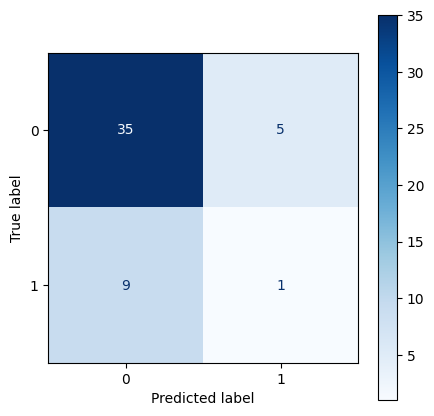

In [ ]:
reg_model.fit(X_train, y_one_rest)

print("accuracy =", accuracy_score(reg_model.predict(X_test), y_test_one_rest))

# confusion matrix is more informative:
matrix = ConfusionMatrixDisplay.from_estimator(
        reg_model,
        X_test,
        y_test_one_rest,
        cmap=plt.cm.Blues
    )
matrix.figure_.set_size_inches(5,5)

With a kind of binary classification this is much better now, but I could improve more my classification, if I try other machine learning models as logistic regression is very robust

#Let's try now Support Vector Machine (SVM) with linear and nonlinear kernels

In [ ]:
clf=svm.SVC(kernel='linear') # first: linear kernel is used here and the original, multiclass dataset:
results_svml=cross_validate(clf,X_train,y_train,cv=10,scoring='accuracy')

print("results:", results_svml['test_score'])
print("mean score:", np.mean(results_svml['test_score']))
print("standardd deviation:", np.std(results_svml['test_score']))
clf.fit(X_train,y_train)

accuracy_score(clf.predict(X_test),y_test)

results: [1.   1.   0.85 0.95 0.9  1.   1.   0.95 0.95 0.95]
mean score: 0.9549999999999998
standardd deviation: 0.04716990566028302


0.98

In [ ]:
clf_p=svm.SVC(kernel='poly') # now: nonlinear kernel and multiclass dataset:
results_svml=cross_validate(clf_p,X_train,y_train,cv=10,scoring='accuracy')

print("results:", results_svml['test_score'])
print("mean score:", np.mean(results_svml['test_score']))
print("standardd deviation:", np.std(results_svml['test_score']))
clf_p.fit(X_train,y_train)

accuracy_score(clf_p.predict(X_test),y_test)

results: [0.95 0.9  0.8  0.95 0.9  0.95 0.95 0.8  0.8  0.9 ]
mean score: 0.89
standardd deviation: 0.06244997998398395


0.88

Well, I expect that SVM is also a kind of binary classification, so I try the one-vs-rest labels. In this case I will use Gaussian rbf kernel, as the article suggested

In [ ]:
clf_G=svm.SVC(kernel='rbf') # now: Gaussian rbf kernel and one-rest labels:
results_svml=cross_validate(clf_G,X_train,y_one_rest,cv=10,scoring='accuracy')

print("results:", results_svml['test_score'])
print("mean score:", np.mean(results_svml['test_score']))
print("standardd deviation:", np.std(results_svml['test_score']))
clf_G.fit(X_train,y_one_rest)

accuracy_score(clf_G.predict(X_test),y_test_one_rest)

results: [1.   1.   0.9  0.95 0.95 0.95 1.   1.   0.95 1.  ]
mean score: 0.97
standardd deviation: 0.033166247903554005


1.0

This seems much better! Now let's plot its confusion matrix and Sebastian's hyperparameter plotting package from the lecture

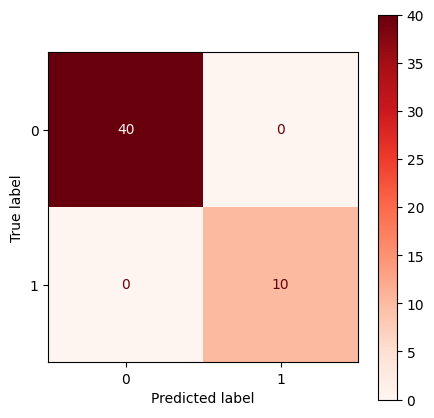

In [ ]:
matrix1 = ConfusionMatrixDisplay.from_estimator(
        clf_G,
        X_test,
        y_test_one_rest,
        cmap=plt.cm.Reds
    )
matrix1.figure_.set_size_inches(5,5)

This is perfect now! Let's see some visualization of the problem. For this option I need to reduce dimensionality with PCA

accuracy = 0.8


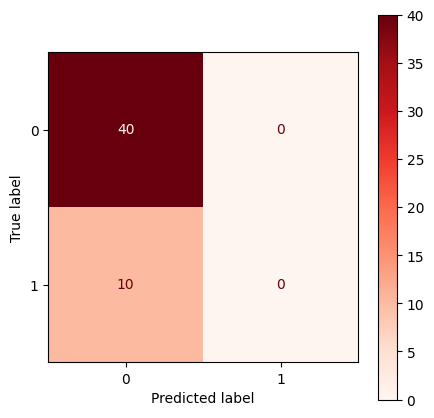

In [ ]:
# For plot_decision_regions, only 2 features of input data is acceptable, so I will retrain my model with manually selected 2 features:
# wrists sensors' x acceleration and  t3 sensor's x acceleration

# also, to be able to get the hyperplane as well, I will use again linear kernel

#X = X_train[['Ax_mean_x', 'Ax_mean_y']]
#Xt = X_test[['Ax_mean_x', 'Ax_mean_y']]
X = X_train[['Acc_vectorial_sum_x', 'Gx_max']]
Xt = X_test[['Acc_vectorial_sum_x', 'Gx_max']]
clf.fit(X,y_one_rest)

print("accuracy =", accuracy_score(clf.predict(Xt),y_test_one_rest))
matrix1 = ConfusionMatrixDisplay.from_estimator(
        clf,
        Xt,
        y_test_one_rest,
        cmap=plt.cm.Reds
    )
matrix1.figure_.set_size_inches(5,5)

based on accuracy it seems just a little worse than before, but confusion matrix shows, there is a problem if I do not consider some other useful features

but this is only to see how svm works here

so first I simply make a scatter plot then try to visualize the support vectors, then try to plot the hyperplane as well

<Axes: xlabel='Acc_vectorial_sum_x', ylabel='Gx_max'>

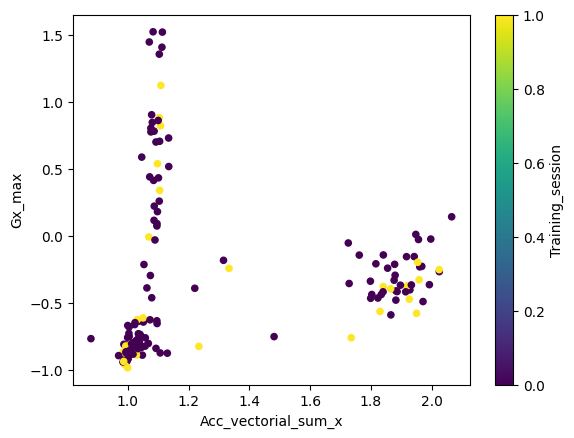

In [ ]:
xy = pd.merge(X, y_one_rest, left_index=True, right_index=True)
xy.plot.scatter(x='Acc_vectorial_sum_x',
                y='Gx_max',
                c='Training_session',
                colormap='viridis')

We can see 2 classes here, somewhat separable but overlapping.

Let's see now the support vectors and hyperplane

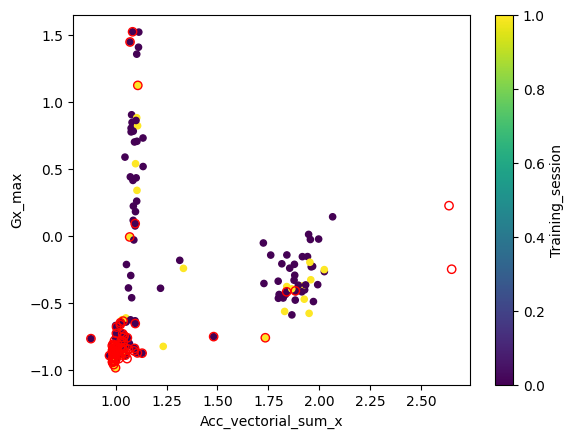

In [ ]:
xy.plot.scatter(x='Acc_vectorial_sum_x',y='Gx_max',c='Training_session',colormap='viridis')
plt.gca().scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                  facecolors="none", edgecolors="r")



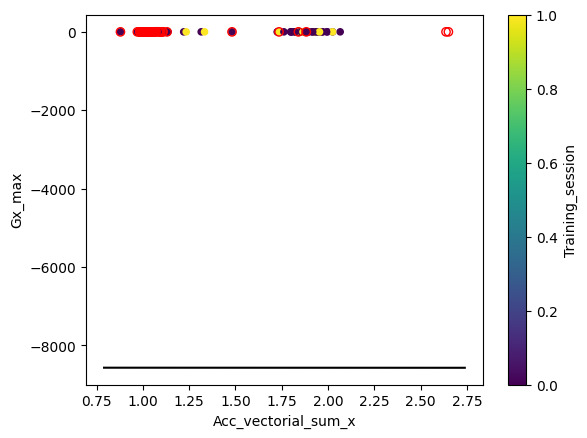

In [ ]:
# The support vectors seems to be inaccurate, as the model is not good enough for this data, or I chose bad features
xy.plot.scatter(x='Acc_vectorial_sum_x',y='Gx_max',c='Training_session',colormap='viridis')
plt.gca().scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                  facecolors="none", edgecolors="r")

# method from the lecture to get the hyperplane as well helps me to plot is as well
def calculate_hyperplane(model):
    x_lim=plt.gca().get_xlim()
    y_lim=plt.gca().get_ylim()
    w = model.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(x_lim[0], x_lim[1])
    yy = a * xx - (model.intercept_[0]) / w[1]
    return (xx,yy)

# Now we plot the hyperplane
plt.gca().plot( *calculate_hyperplane(clf), 'k-')

accuracy = 0.8


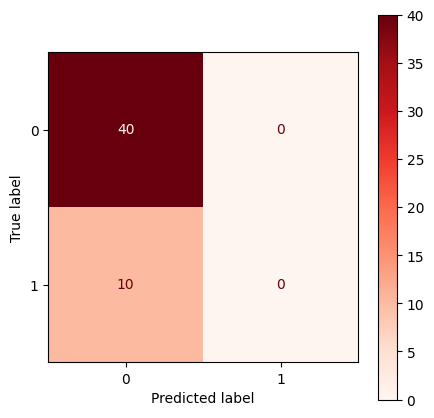

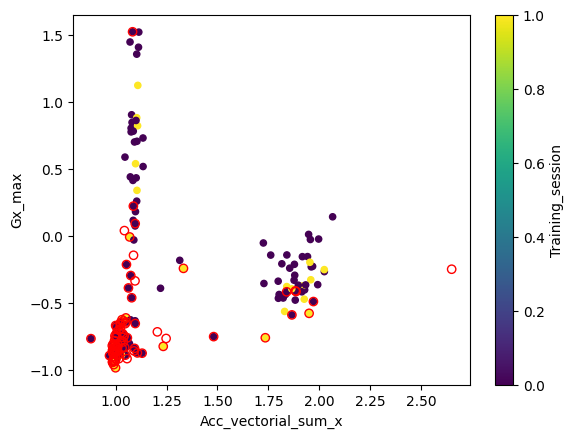

In [ ]:
# This really shows, this set is not good.

# without hyperplane, but check supportvectors in poly and then rbf kernel case:
clf_p.fit(X,y_one_rest)

print("accuracy =", accuracy_score(clf_p.predict(Xt),y_test_one_rest))
matrix1 = ConfusionMatrixDisplay.from_estimator(
        clf_p,
        Xt,
        y_test_one_rest,
        cmap=plt.cm.Reds
    )
matrix1.figure_.set_size_inches(5,5)

xy.plot.scatter(x='Acc_vectorial_sum_x',y='Gx_max',c='Training_session',colormap='viridis')
plt.gca().scatter(clf_p.support_vectors_[:, 0], clf_p.support_vectors_[:, 1],
                  facecolors="none", edgecolors="r")


the accuracy is somewhat better then with all the features, support vectors seemss to be also somewhat better than in linear kernel case, however still strange results

accuracy = 0.8


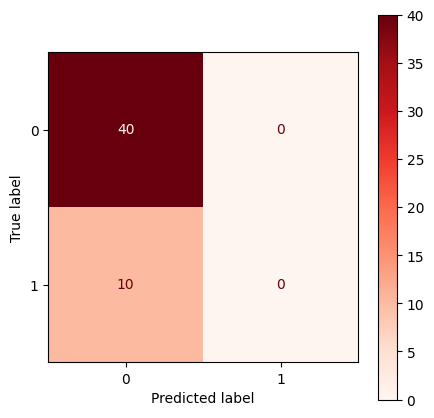

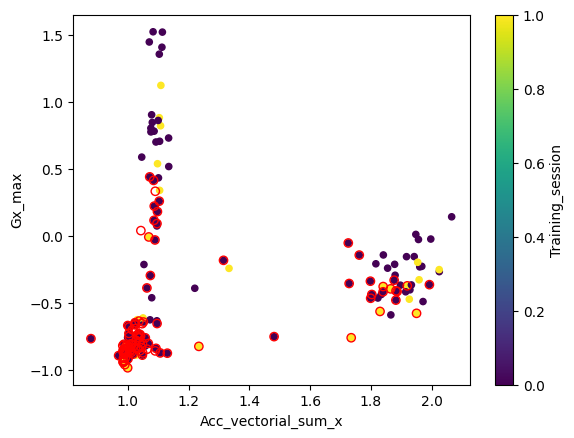

In [ ]:
clf_G.fit(X,y_one_rest)

print("accuracy =", accuracy_score(clf_G.predict(Xt),y_test_one_rest))
matrix1 = ConfusionMatrixDisplay.from_estimator(
        clf_G,
        Xt,
        y_test_one_rest,
        cmap=plt.cm.Reds
    )
matrix1.figure_.set_size_inches(5,5)

xy.plot.scatter(x='Acc_vectorial_sum_x',y='Gx_max',c='Training_session',colormap='viridis')
plt.gca().scatter(clf_G.support_vectors_[:, 0], clf_G.support_vectors_[:, 1],
                  facecolors="none", edgecolors="r")


accuracy and support vectors are better then in previous 2 analysis, but worse accuracy then rbf kernel svm with all the original features

<Axes: >

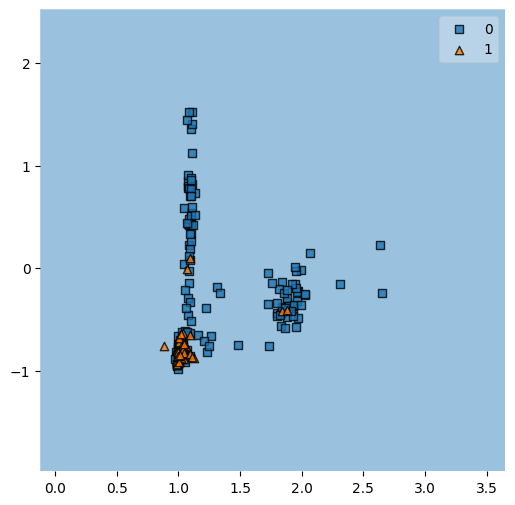

In [ ]:
#In this case I might be able to use Sebastian's great descision region from the lecture:
plt.figure(figsize=(6,6))
plot_decision_regions(X.to_numpy(), y_one_rest.values.flatten(), clf, ax=plt.gca())

<Axes: >

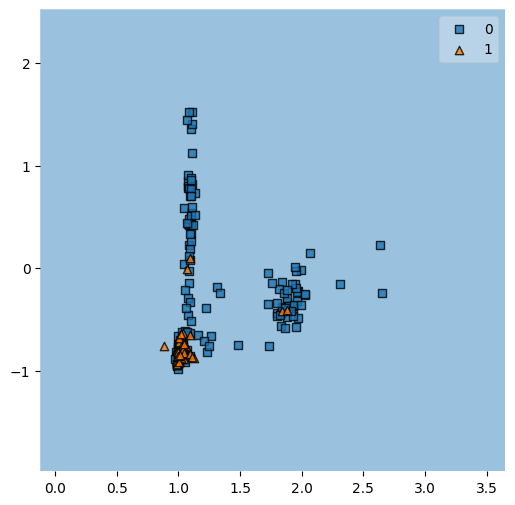

In [ ]:
plt.figure(figsize=(6,6))
plot_decision_regions(X.to_numpy(), y_one_rest.values.flatten(), clf_p, ax=plt.gca())

<Axes: >

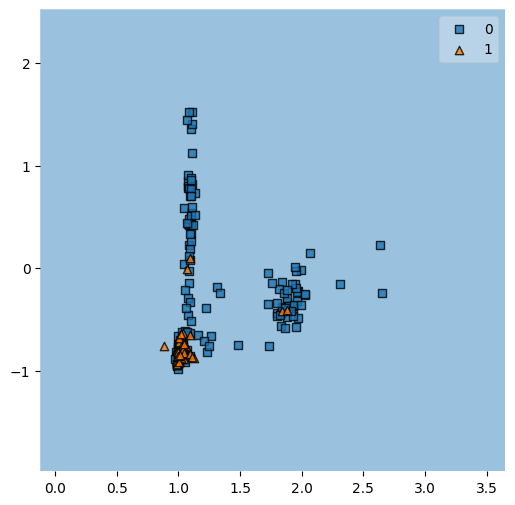

In [ ]:
plt.figure(figsize=(6,6))
plot_decision_regions(X.to_numpy(), y_one_rest.values.flatten(), clf_G, ax=plt.gca())

Instead of selecting manually 2 features, it is a much better aproach to use PCA-like dimensionality reduction, but for supervised learning

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(inputData, df_y)
#print(lda.get_feature_names_out())
LDA = pd.DataFrame(lda.transform(inputData), columns=lda.get_feature_names_out())
LDA_X_train, LDA_X_test, LDA_y_train, LDA_y_test = train_test_split(LDA, df_y, test_size=0.22, random_state=42)

#still need one-vs-rest classes:
LDA_y_one_rest = pd.DataFrame(np.where(LDA_y_train['Training_session']=="Left_hook", 1, 0), columns=['Training_session'])
LDA_y_test_one_rest = pd.DataFrame(np.where(LDA_y_test['Training_session']=="Left_hook", 1, 0), columns=['Training_session'])

LDA_X_train

,lineardiscriminantanalysis0,lineardiscriminantanalysis1
66,-22.215908,-15.775016
217,36.128305,-0.019697
154,22.057900,2.814532
168,20.521618,-0.231373
229,37.330069,-1.914472
...,...,...
106,-0.722716,8.584620
14,-36.304059,6.118019
92,-20.537270,-14.553650
179,21.062984,0.529476


In [ ]:
LDA_y_one_rest

,Training_session
0,0
1,0
2,0
3,0
4,0
...,...
190,1
191,0
192,0
193,0


Now we can try to refit our svm models and make some plots

accuracy = 0.9818181818181818


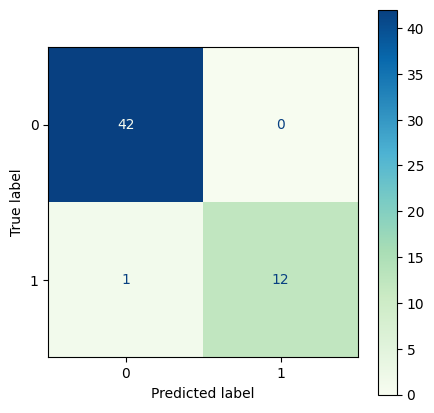

In [ ]:
# svm with linear kernel
clf.fit(LDA_X_train, LDA_y_one_rest)

print("accuracy =", accuracy_score(clf.predict(LDA_X_test),LDA_y_test_one_rest))
matrix1 = ConfusionMatrixDisplay.from_estimator(
        clf,
        LDA_X_test,
        LDA_y_test_one_rest,
        cmap=plt.cm.GnBu
    )
matrix1.figure_.set_size_inches(5,5)

Very good results, now let's visualize as well

<Axes: >

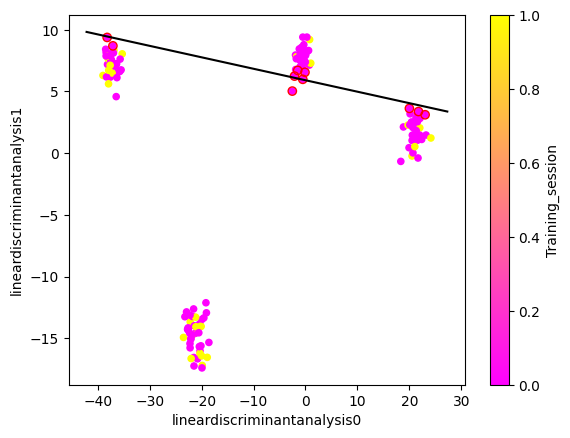

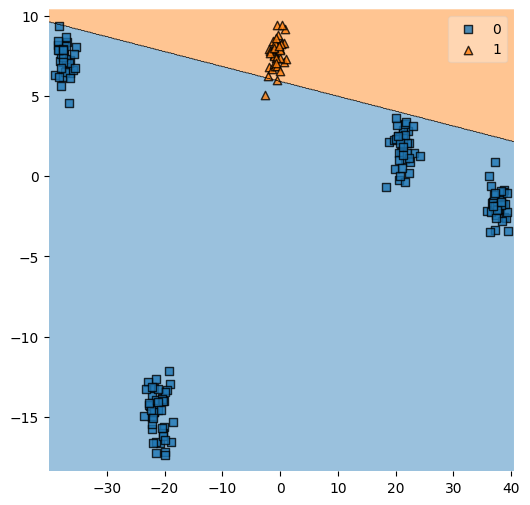

In [ ]:
xy = pd.merge(LDA_X_train, LDA_y_one_rest, left_index=True, right_index=True)

xy.plot.scatter(x='lineardiscriminantanalysis0',y='lineardiscriminantanalysis1',c='Training_session',colormap='spring')
plt.gca().scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                  facecolors="none", edgecolors="r")

# method from the lecture to get the hyperplane as well helps me to plot is as well
def calculate_hyperplane(model):
    x_lim=plt.gca().get_xlim()
    y_lim=plt.gca().get_ylim()
    w = model.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(x_lim[0], x_lim[1])
    yy = a * xx - (model.intercept_[0]) / w[1]
    return (xx,yy)

# Now we plot the hyperplane
plt.gca().plot( *calculate_hyperplane(clf), 'k-')

plt.figure(figsize=(6,6))
plot_decision_regions(LDA_X_train.to_numpy(), LDA_y_one_rest.values.flatten(), clf, ax=plt.gca())

Now it is clearly separable by a hyperplane. But let's see the other 2 kernel types as well:

accuracy = 0.7636363636363637


<Axes: >

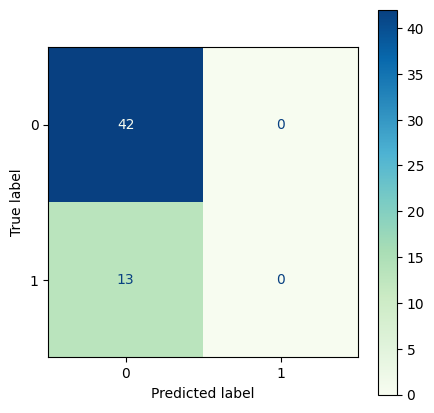

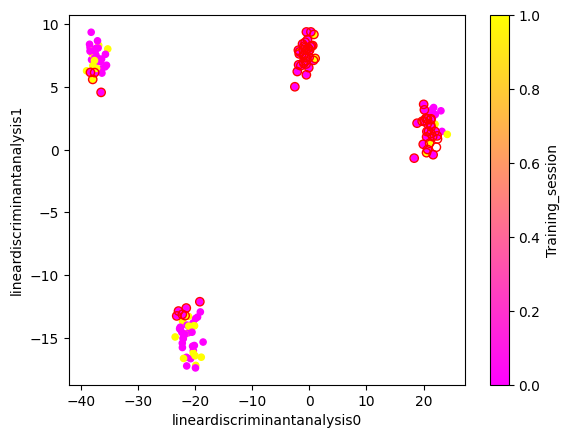

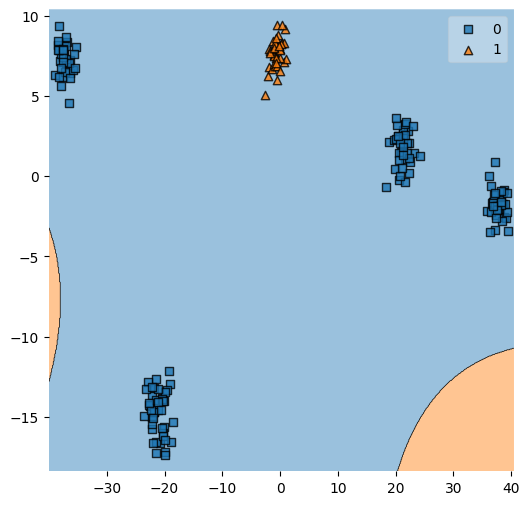

In [ ]:
#clf_p: nonlinear 'poly' kernel:
#first refit the model:
clf_p.fit(LDA_X_train, LDA_y_one_rest)

#check confusion matrix:
print("accuracy =", accuracy_score(clf_p.predict(LDA_X_test),LDA_y_test_one_rest))
matrix1 = ConfusionMatrixDisplay.from_estimator(
        clf_p,
        LDA_X_test,
        LDA_y_test_one_rest,
        cmap=plt.cm.GnBu
    )
matrix1.figure_.set_size_inches(5,5)

#visualize:
xy = pd.merge(LDA_X_train, LDA_y_one_rest, left_index=True, right_index=True)

xy.plot.scatter(x='lineardiscriminantanalysis0',y='lineardiscriminantanalysis1',c='Training_session',colormap='spring')
plt.gca().scatter(clf_p.support_vectors_[:, 0], clf_p.support_vectors_[:, 1],
                  facecolors="none", edgecolors="r")

plt.figure(figsize=(6,6))
plot_decision_regions(LDA_X_train.to_numpy(), LDA_y_one_rest.values.flatten(), clf_p, ax=plt.gca())

This not works well, but we can still check the rbf kernel:

accuracy = 1.0


<Axes: >

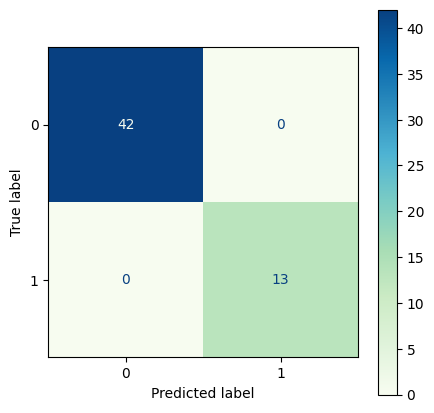

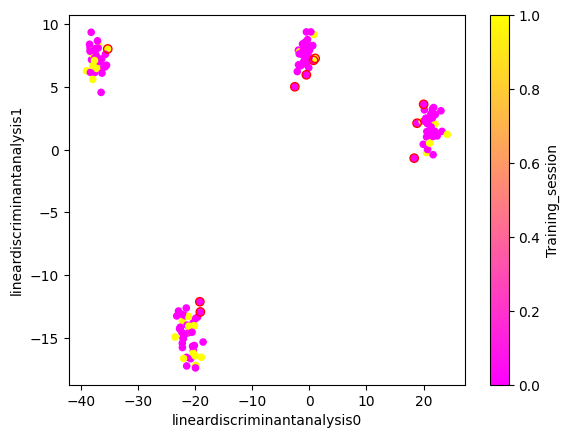

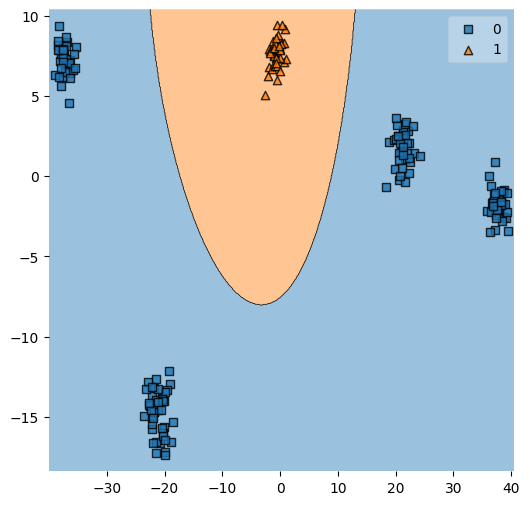

In [ ]:
#clf_G: nonlinear 'poly' kernel:
#first refit the model:
clf_G.fit(LDA_X_train, LDA_y_one_rest)

#check confusion matrix:
print("accuracy =", accuracy_score(clf_G.predict(LDA_X_test),LDA_y_test_one_rest))
matrix1 = ConfusionMatrixDisplay.from_estimator(
        clf_G,
        LDA_X_test,
        LDA_y_test_one_rest,
        cmap=plt.cm.GnBu
    )
matrix1.figure_.set_size_inches(5,5)

#visualize:
xy = pd.merge(LDA_X_train, LDA_y_one_rest, left_index=True, right_index=True)

xy.plot.scatter(x='lineardiscriminantanalysis0',y='lineardiscriminantanalysis1',c='Training_session',colormap='spring')
plt.gca().scatter(clf_G.support_vectors_[:, 0], clf_G.support_vectors_[:, 1],
                  facecolors="none", edgecolors="r")

plt.figure(figsize=(6,6))
plot_decision_regions(LDA_X_train.to_numpy(), LDA_y_one_rest.values.flatten(), clf_G, ax=plt.gca())

#Now I move on to see what happenes if I apply decision trees on the data with all types of stikes

accuracy = 0.28


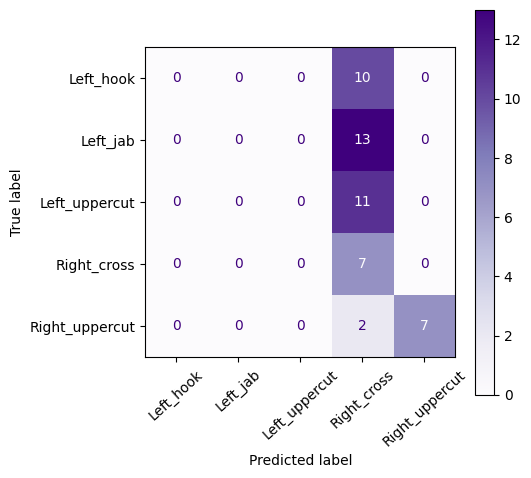

In [ ]:
#first try 1 depth of tree
decTree=DecisionTreeClassifier(max_depth=1, random_state=42)
decTree.fit(X_train,y_train)

# check the model's accuracy and confusion matrix:
print("accuracy =", accuracy_score(decTree.predict(X_test), y_test))
matrix2 = ConfusionMatrixDisplay.from_estimator(
        decTree,
        X_test,
        y_test,
        cmap=plt.cm.Purples,
        xticks_rotation=42
    )
matrix2.figure_.set_size_inches(5,5)

[Text(0.5, 0.75, 'Roll_minpos <= 60358.0\ngini = 0.8\nsamples = 200\nvalue = [40, 37, 39, 43, 41]\nclass = Right_cross'),
 Text(0.25, 0.25, 'gini = 0.749\nsamples = 159\nvalue = [40, 37, 39, 43, 0]\nclass = Right_cross'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 41\nvalue = [0, 0, 0, 0, 41]\nclass = Right_uppercut')]

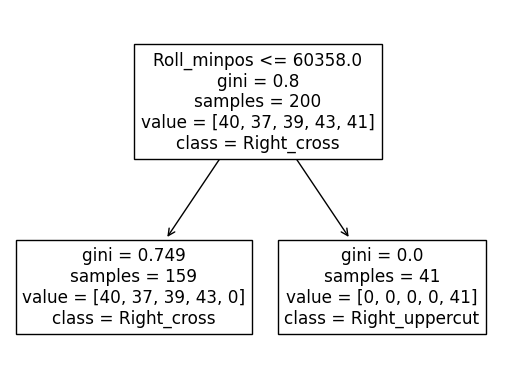

In [ ]:
# now visualize the decisionn tree itself as this gave very bad results:
plot_tree(decTree, feature_names=X_train.columns, class_names=np.unique(y_train.astype(str)))

This 1 depth tree mostly made splits on 1 feature. I need more levels of the tree and consider more classes

In [ ]:
models = {}
models["dt_1"]=DecisionTreeClassifier(max_depth=1, random_state=42)
models["dt_2"]=DecisionTreeClassifier(max_depth=2, random_state=42)
models["dt_3"]=DecisionTreeClassifier(max_depth=3, random_state=42)
models["dt_4"]=DecisionTreeClassifier(max_depth=4, random_state=42)
models["dt_5"]=DecisionTreeClassifier(max_depth=5, random_state=42)
models["dt_unbounded"]=DecisionTreeClassifier(random_state=42)

for label, model in models.items():
    results=cross_validate(model,X_train,y_train,cv=10,scoring='accuracy')
    cv_acc=np.mean(results['test_score'])
    val_acc=model.fit(X_train,y_train).score(X_train,y_train)
    #model.fit(X_train, y_train)
    #pred = decTree.predict(X_test)
    #commented out accuracy and precision, as cross validation's scores really shows better how better the decision trees will be with increasing levels/depth
    #print(label, "accuracy =", accuracy_score(pred, y_test), "precision =", precision_score(pred, y_test, average=None))
    print(label, "cv_acc =", cv_acc, "val_acc=", val_acc)


dt_1 cv_acc = 0.41500000000000004 val_acc= 0.42
dt_2 cv_acc = 0.6249999999999999 val_acc= 0.62
dt_3 cv_acc = 0.9650000000000001 val_acc= 1.0
dt_4 cv_acc = 0.985 val_acc= 1.0
dt_5 cv_acc = 0.985 val_acc= 1.0
dt_unbounded cv_acc = 0.985 val_acc= 1.0


Based on the scores from 4 levels of decision tree model should not improve further, so let's see it's confusion matrix and tree plotted

['Left_hook' 'Left_jab' 'Right_cross' 'Right_cross' 'Left_hook'
 'Left_uppercut' 'Left_uppercut' 'Left_uppercut' 'Left_jab' 'Left_hook'
 'Left_uppercut' 'Right_uppercut' 'Right_uppercut' 'Right_uppercut'
 'Right_cross' 'Right_uppercut' 'Left_uppercut' 'Left_jab' 'Left_uppercut'
 'Left_jab' 'Right_uppercut' 'Left_jab' 'Left_hook' 'Right_cross'
 'Left_uppercut' 'Left_jab' 'Right_cross' 'Left_jab' 'Left_jab'
 'Left_hook' 'Left_uppercut' 'Left_jab' 'Left_hook' 'Right_uppercut'
 'Left_jab' 'Left_hook' 'Left_jab' 'Left_uppercut' 'Left_uppercut'
 'Left_uppercut' 'Left_hook' 'Right_cross' 'Left_hook' 'Left_uppercut'
 'Right_uppercut' 'Left_jab' 'Left_hook' 'Right_cross' 'Left_uppercut'
 'Left_jab']


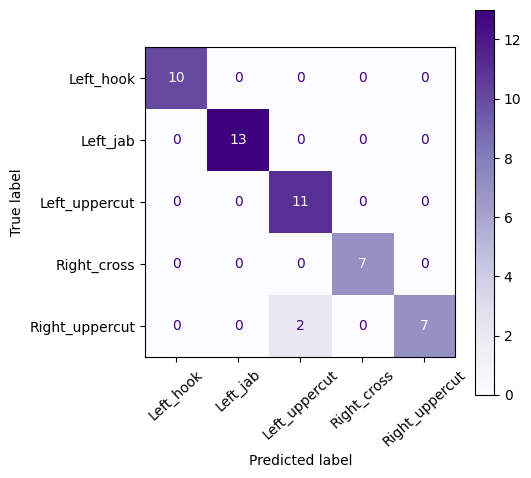

In [ ]:
matrix2 = ConfusionMatrixDisplay.from_estimator(
        models["dt_4"],
        X_test,
        y_test,
        cmap=plt.cm.Purples,
        xticks_rotation=42
    )
matrix2.figure_.set_size_inches(5,5)
print(models["dt_unbounded"].predict(X_test))

[Text(0.625, 0.875, 'Roll_minpos <= 60358.0\ngini = 0.8\nsamples = 200\nvalue = [40, 37, 39, 43, 41]\nclass = Right_cross'),
 Text(0.5, 0.625, 'Ay_maxpos_x <= 30015.0\ngini = 0.749\nsamples = 159\nvalue = [40, 37, 39, 43, 0]\nclass = Right_cross'),
 Text(0.25, 0.375, 'Gx_maxpos <= 14943.5\ngini = 0.497\nsamples = 80\nvalue = [0, 37, 0, 43, 0]\nclass = Right_cross'),
 Text(0.125, 0.125, 'gini = 0.0\nsamples = 37\nvalue = [0, 37, 0, 0, 0]\nclass = Left_jab'),
 Text(0.375, 0.125, 'gini = 0.0\nsamples = 43\nvalue = [0, 0, 0, 43, 0]\nclass = Right_cross'),
 Text(0.75, 0.375, 'Roll_minpos_y <= 44983.0\ngini = 0.5\nsamples = 79\nvalue = [40, 0, 39, 0, 0]\nclass = Left_hook'),
 Text(0.625, 0.125, 'gini = 0.0\nsamples = 40\nvalue = [40, 0, 0, 0, 0]\nclass = Left_hook'),
 Text(0.875, 0.125, 'gini = 0.0\nsamples = 39\nvalue = [0, 0, 39, 0, 0]\nclass = Left_uppercut'),
 Text(0.75, 0.625, 'gini = 0.0\nsamples = 41\nvalue = [0, 0, 0, 0, 41]\nclass = Right_uppercut')]

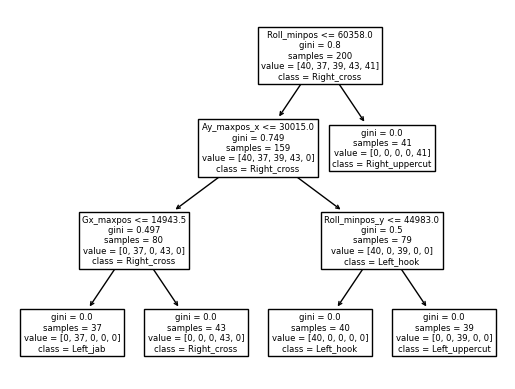

In [ ]:
plot_tree(models["dt_4"], feature_names=X_train.columns, class_names=np.unique(y_train.astype(str)))

I would like to have a look at the unbounded decision tree as well

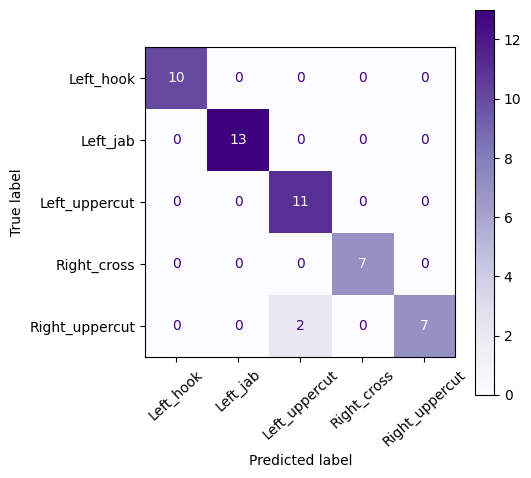

In [ ]:
matrix2 = ConfusionMatrixDisplay.from_estimator(
        models["dt_unbounded"],
        X_test,
        y_test,
        cmap=plt.cm.Purples,
        xticks_rotation=42
    )
matrix2.figure_.set_size_inches(5,5)

[Text(0.625, 0.875, 'Roll_minpos <= 60358.0\ngini = 0.8\nsamples = 200\nvalue = [40, 37, 39, 43, 41]\nclass = Right_cross'),
 Text(0.5, 0.625, 'Ay_maxpos_x <= 30015.0\ngini = 0.749\nsamples = 159\nvalue = [40, 37, 39, 43, 0]\nclass = Right_cross'),
 Text(0.25, 0.375, 'Gx_maxpos <= 14943.5\ngini = 0.497\nsamples = 80\nvalue = [0, 37, 0, 43, 0]\nclass = Right_cross'),
 Text(0.125, 0.125, 'gini = 0.0\nsamples = 37\nvalue = [0, 37, 0, 0, 0]\nclass = Left_jab'),
 Text(0.375, 0.125, 'gini = 0.0\nsamples = 43\nvalue = [0, 0, 0, 43, 0]\nclass = Right_cross'),
 Text(0.75, 0.375, 'Roll_minpos_y <= 44983.0\ngini = 0.5\nsamples = 79\nvalue = [40, 0, 39, 0, 0]\nclass = Left_hook'),
 Text(0.625, 0.125, 'gini = 0.0\nsamples = 40\nvalue = [40, 0, 0, 0, 0]\nclass = Left_hook'),
 Text(0.875, 0.125, 'gini = 0.0\nsamples = 39\nvalue = [0, 0, 39, 0, 0]\nclass = Left_uppercut'),
 Text(0.75, 0.625, 'gini = 0.0\nsamples = 41\nvalue = [0, 0, 0, 0, 41]\nclass = Right_uppercut')]

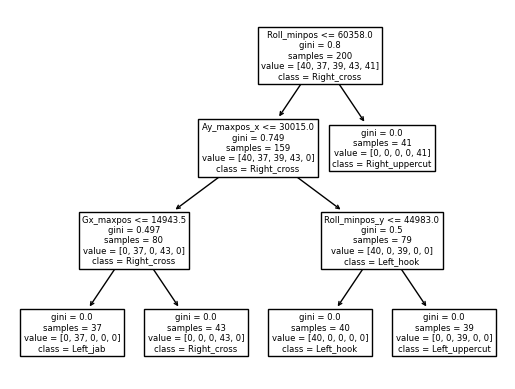

In [ ]:
plot_tree(models["dt_unbounded"], feature_names=X_train.columns, class_names=np.unique(y_train.astype(str)))

The best choice here is really the 4-depth decision tree

#Now I would experiement a little with ensemble models as well

In [ ]:
# I just extend my models list with some new ones:
models['min_3'] = DecisionTreeClassifier(min_samples_split=3, random_state=42)
models['entropy'] = DecisionTreeClassifier(criterion='entropy', random_state=42)
models['alpha_2'] = DecisionTreeClassifier(ccp_alpha=0.2, random_state=42)

In [ ]:
voters=VotingClassifier(estimators=[('dt_4', models["dt_4"]), ('min_3', models["min_3"]),
                                    ('entropy', models["entropy"]),
                                     ('alpha_2', models["alpha_2"])], n_jobs=-1)
voters.fit(X_train,y_train)

VotingClassifier(estimators=[('dt_4',
                              DecisionTreeClassifier(max_depth=4,
                                                     random_state=42)),
                             ('min_3',
                              DecisionTreeClassifier(min_samples_split=3,
                                                     random_state=42)),
                             ('entropy',
                              DecisionTreeClassifier(criterion='entropy',
                                                     random_state=42)),
                             ('alpha_2',
                              DecisionTreeClassifier(ccp_alpha=0.2,
                                                     random_state=42))],
                 n_jobs=-1)

scores = 1.0 test_scores = 0.96


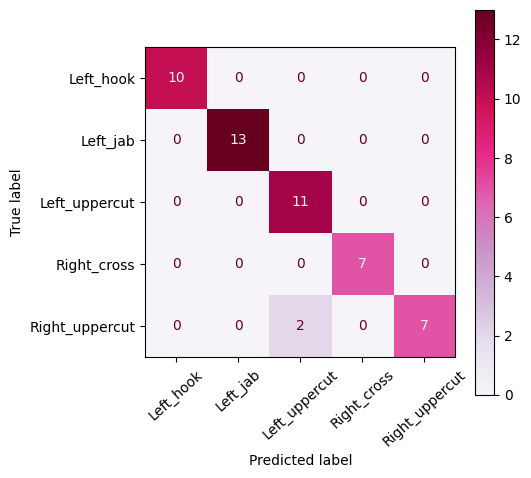

In [ ]:
# now see some evaluations

print("scores =", voters.score(X_train, y_train), "test_scores =", voters.score(X_test, y_test))

matrix2 = ConfusionMatrixDisplay.from_estimator(
        voters,
        X_test,
        y_test,
        cmap=plt.cm.PuRd,
        xticks_rotation=42
    )
matrix2.figure_.set_size_inches(5,5)

1.0 score is really good!

And it seems the confusion matrix is the same as in the case of 4-depth decision tree, so this is the best choice so far

In [ ]:
# let's also see a full classification report:
voter_predicted = voters.predict(X_test)
print(classification_report(y_test, voter_predicted))

                precision    recall  f1-score   support

     Left_hook       1.00      1.00      1.00        10
      Left_jab       1.00      1.00      1.00        13
 Left_uppercut       0.85      1.00      0.92        11
   Right_cross       1.00      1.00      1.00         7
Right_uppercut       1.00      0.78      0.88         9

      accuracy                           0.96        50
     macro avg       0.97      0.96      0.96        50
  weighted avg       0.97      0.96      0.96        50



I am curious about how the models perfom which were used by the article's authors.

Half of them I already made here previously and I will try 2 more.

First, gradient boosting, and finally random forest

#First, gradient boosting

In [ ]:
xgb = GradientBoostingClassifier(min_samples_leaf=3, max_depth=5, n_estimators=30, random_state=42, learning_rate=1.0)
xgb.fit(X_train, y_train)

xgb.n_estimators

30

Because it used all estimators, I can use more maybe

In [ ]:
xgb = GradientBoostingClassifier(min_samples_leaf=3, max_depth=5, n_estimators=3000, random_state=42, learning_rate=1.0)
xgb.fit(X_train, y_train)

xgb.n_estimators

3000

scores = 1.0 test scores =  0.96
                precision    recall  f1-score   support

     Left_hook       1.00      1.00      1.00        10
      Left_jab       1.00      1.00      1.00        13
 Left_uppercut       0.85      1.00      0.92        11
   Right_cross       1.00      1.00      1.00         7
Right_uppercut       1.00      0.78      0.88         9

      accuracy                           0.96        50
     macro avg       0.97      0.96      0.96        50
  weighted avg       0.97      0.96      0.96        50



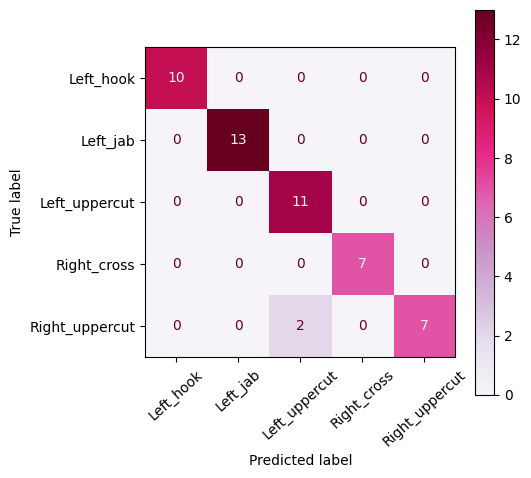

In [ ]:
#check the scores and report, as well as plot the confusion matrix
print("scores =", xgb.score(X_train, y_train), "test scores = ", xgb.score(X_test, y_test))
xgb_predicted = xgb.predict(X_test)
print(classification_report(y_test, xgb_predicted))

matrix2 = ConfusionMatrixDisplay.from_estimator(
        xgb,
        X_test,
        y_test,
        cmap=plt.cm.PuRd,
        xticks_rotation=42
    )
matrix2.figure_.set_size_inches(5,5)

I don't think this is getting better on this data set as already quite good

#Finally make a random forest

cv_acc = 0.99 val_acc= 1.0
                precision    recall  f1-score   support

     Left_hook       1.00      1.00      1.00        10
      Left_jab       1.00      1.00      1.00        13
 Left_uppercut       0.85      1.00      0.92        11
   Right_cross       1.00      1.00      1.00         7
Right_uppercut       1.00      0.78      0.88         9

      accuracy                           0.96        50
     macro avg       0.97      0.96      0.96        50
  weighted avg       0.97      0.96      0.96        50



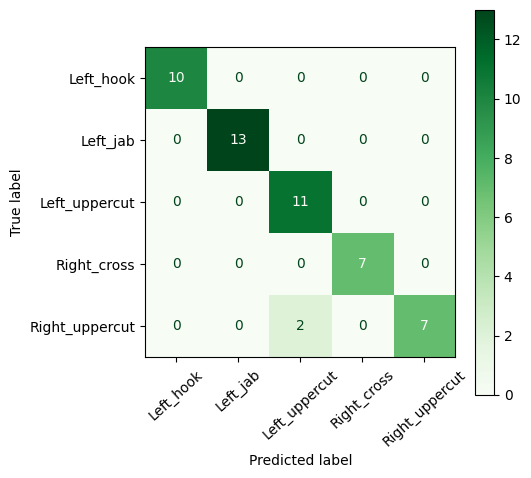

In [ ]:
rf = RandomForestClassifier( random_state=0)

results=cross_validate(rf, X_train, y_train, cv=10, scoring='accuracy')
cv_acc=np.mean(results['test_score'])
val_acc=rf.fit(X_train,y_train).score(X_train,y_train)
print("cv_acc =", cv_acc, "val_acc=", val_acc)

rf_pred = rf.predict(X_test)
print(classification_report(y_test, rf_pred))

matrix2 = ConfusionMatrixDisplay.from_estimator(
        rf,
        X_test,
        y_test,
        cmap=plt.cm.Greens,
        xticks_rotation=42
    )
matrix2.figure_.set_size_inches(5,5)

For me this model seems the best so far

In [ ]:
rf.estimators_

[DecisionTreeClassifier(max_features='sqrt', random_state=209652396),
 DecisionTreeClassifier(max_features='sqrt', random_state=398764591),
 DecisionTreeClassifier(max_features='sqrt', random_state=924231285),
 DecisionTreeClassifier(max_features='sqrt', random_state=1478610112),
 DecisionTreeClassifier(max_features='sqrt', random_state=441365315),
 DecisionTreeClassifier(max_features='sqrt', random_state=1537364731),
 DecisionTreeClassifier(max_features='sqrt', random_state=192771779),
 DecisionTreeClassifier(max_features='sqrt', random_state=1491434855),
 DecisionTreeClassifier(max_features='sqrt', random_state=1819583497),
 DecisionTreeClassifier(max_features='sqrt', random_state=530702035),
 DecisionTreeClassifier(max_features='sqrt', random_state=626610453),
 DecisionTreeClassifier(max_features='sqrt', random_state=1650906866),
 DecisionTreeClassifier(max_features='sqrt', random_state=1879422756),
 DecisionTreeClassifier(max_features='sqrt', random_state=1277901399),
 DecisionTree

[Text(0.625, 0.875, 'Roll_minpos <= 60358.0\ngini = 0.8\nsamples = 200\nvalue = [40, 37, 39, 43, 41]\nclass = Right_cross'),
 Text(0.5, 0.625, 'Ay_maxpos_x <= 30015.0\ngini = 0.749\nsamples = 159\nvalue = [40, 37, 39, 43, 0]\nclass = Right_cross'),
 Text(0.25, 0.375, 'Gx_maxpos <= 14943.5\ngini = 0.497\nsamples = 80\nvalue = [0, 37, 0, 43, 0]\nclass = Right_cross'),
 Text(0.125, 0.125, 'gini = 0.0\nsamples = 37\nvalue = [0, 37, 0, 0, 0]\nclass = Left_jab'),
 Text(0.375, 0.125, 'gini = 0.0\nsamples = 43\nvalue = [0, 0, 0, 43, 0]\nclass = Right_cross'),
 Text(0.75, 0.375, 'Roll_minpos_y <= 44983.0\ngini = 0.5\nsamples = 79\nvalue = [40, 0, 39, 0, 0]\nclass = Left_hook'),
 Text(0.625, 0.125, 'gini = 0.0\nsamples = 40\nvalue = [40, 0, 0, 0, 0]\nclass = Left_hook'),
 Text(0.875, 0.125, 'gini = 0.0\nsamples = 39\nvalue = [0, 0, 39, 0, 0]\nclass = Left_uppercut'),
 Text(0.75, 0.625, 'gini = 0.0\nsamples = 41\nvalue = [0, 0, 0, 0, 41]\nclass = Right_uppercut')]

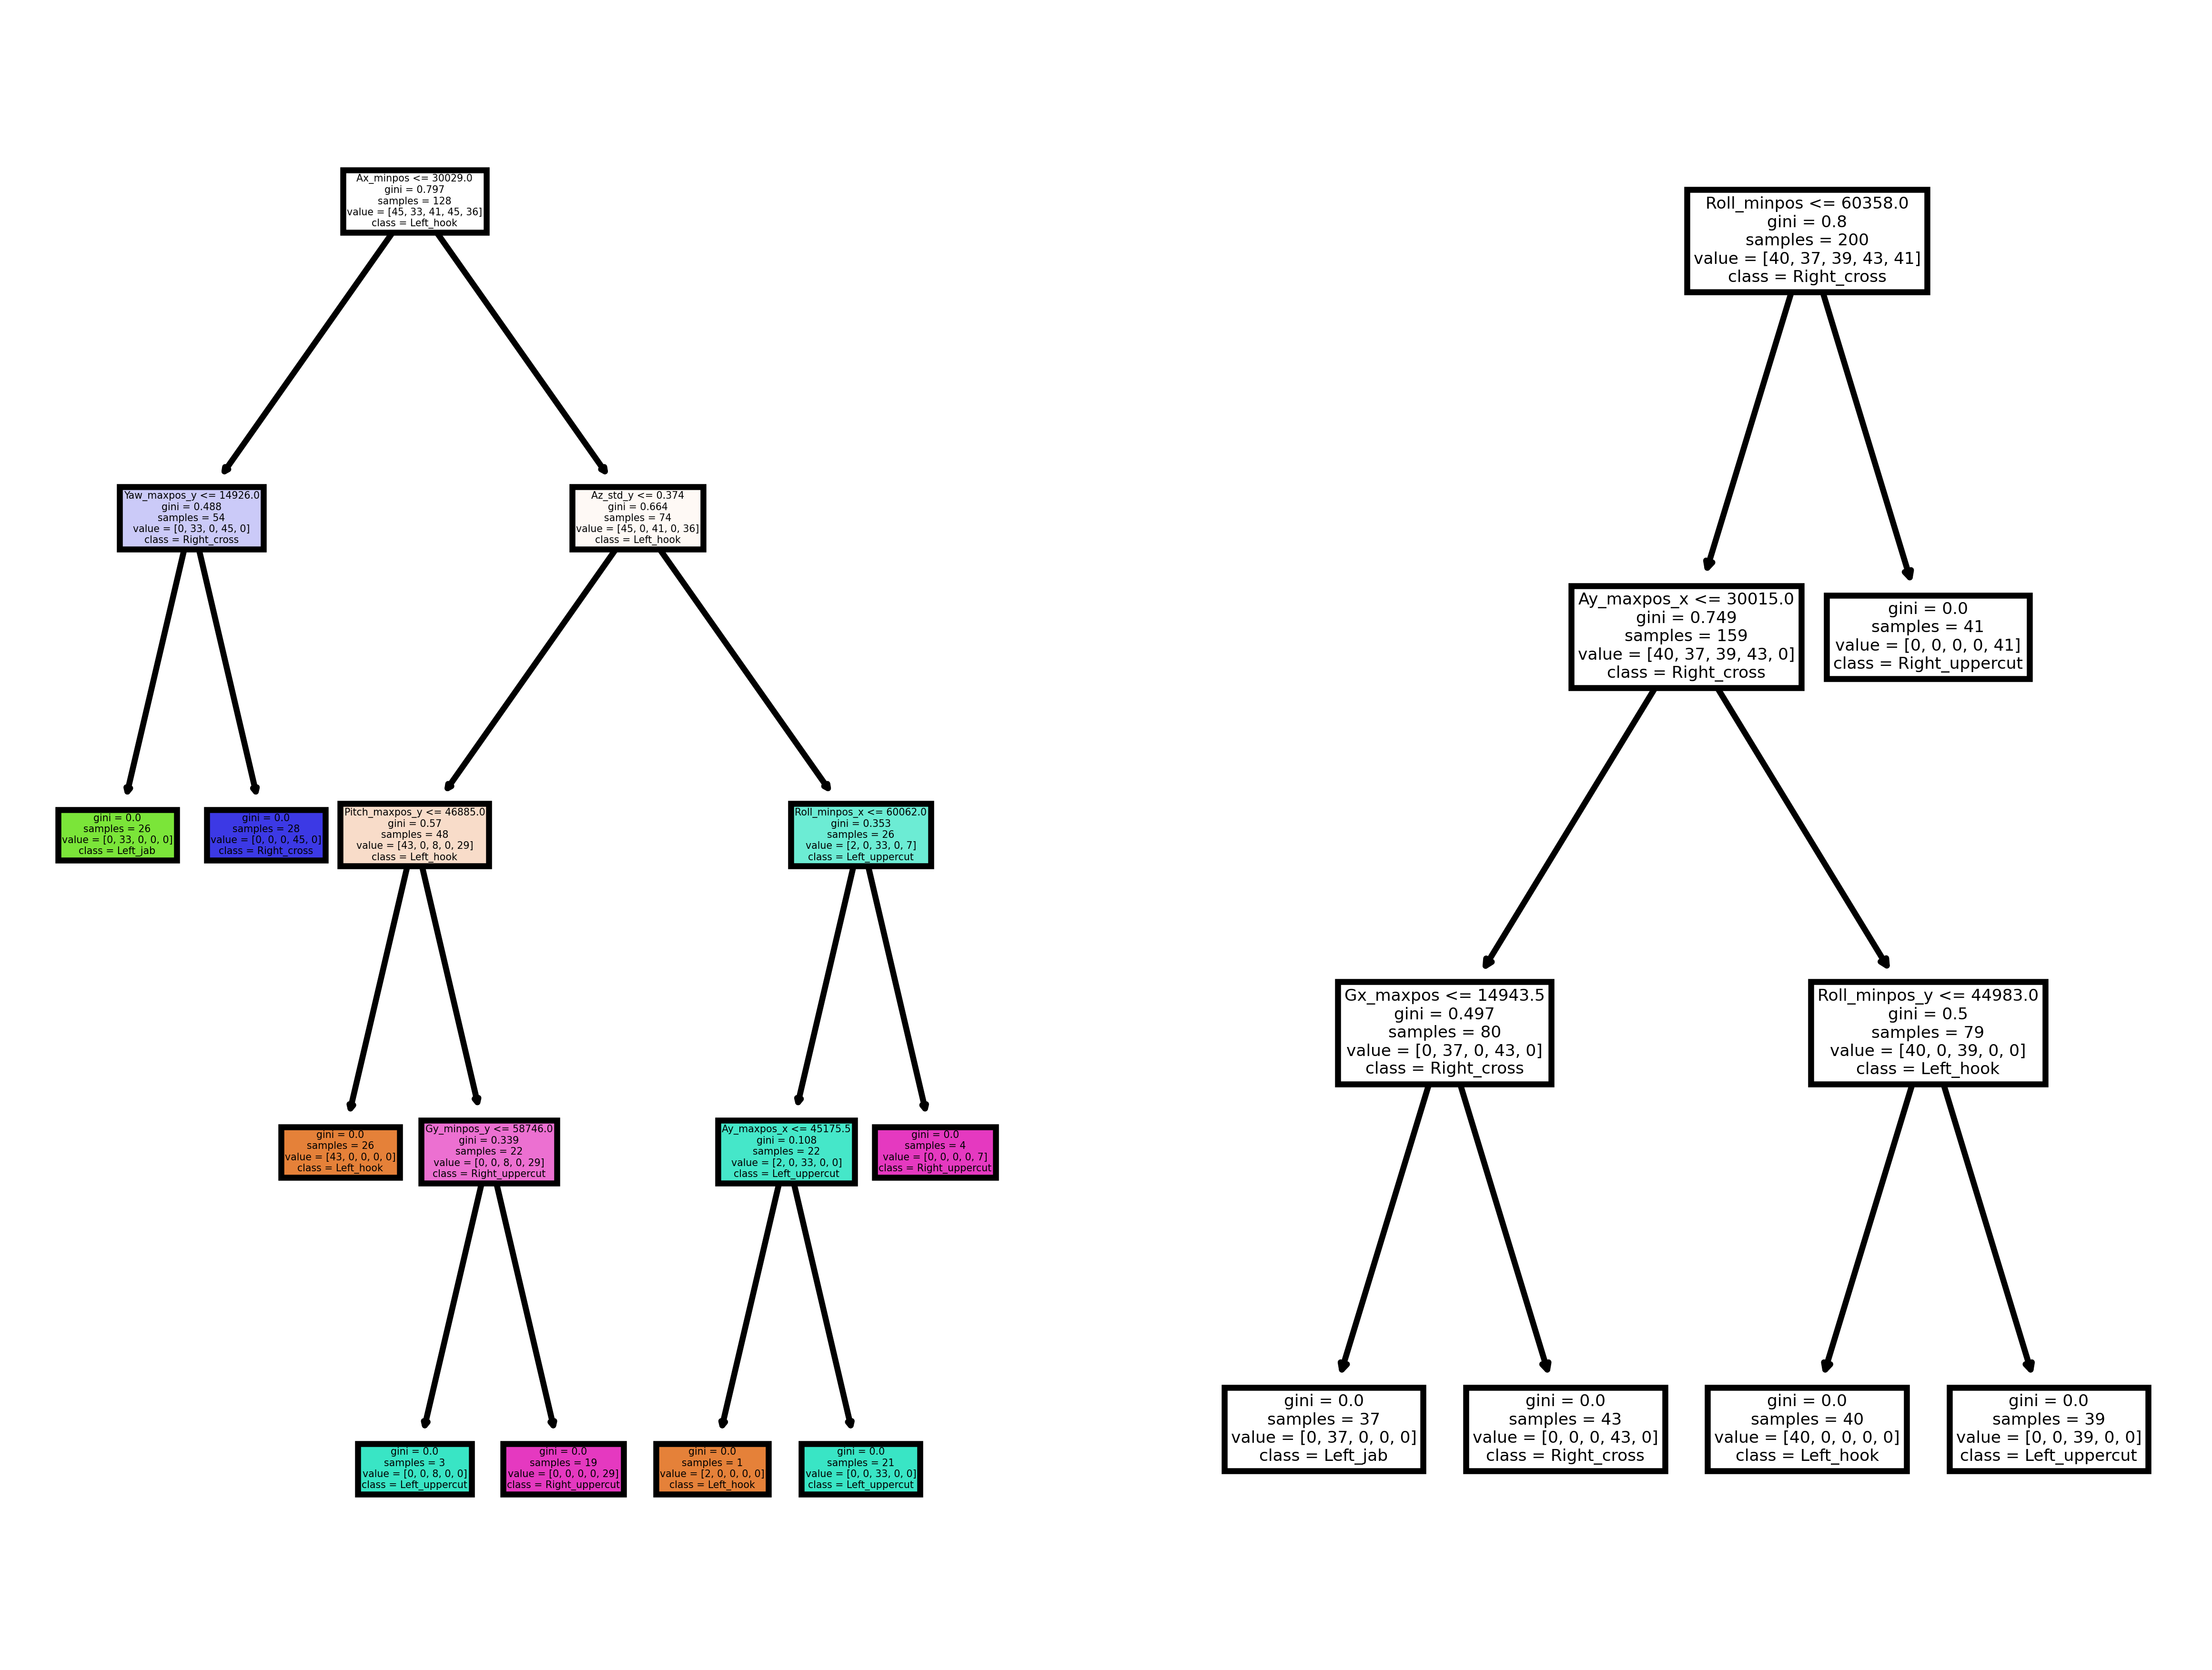

In [ ]:
from sklearn import tree
fig, (ax1, ax2) = plt.subplots(nrows = 1,ncols = 2, dpi=900)
tree.plot_tree(rf.estimators_[0],feature_names=X_train.columns, class_names=np.unique(y_train.astype(str)),
               filled = True, ax=ax1)

plot_tree(models["dt_4"], feature_names=X_train.columns, class_names=np.unique(y_train.astype(str)), ax=ax2)

Because this creates a forest, let's see some of its trees

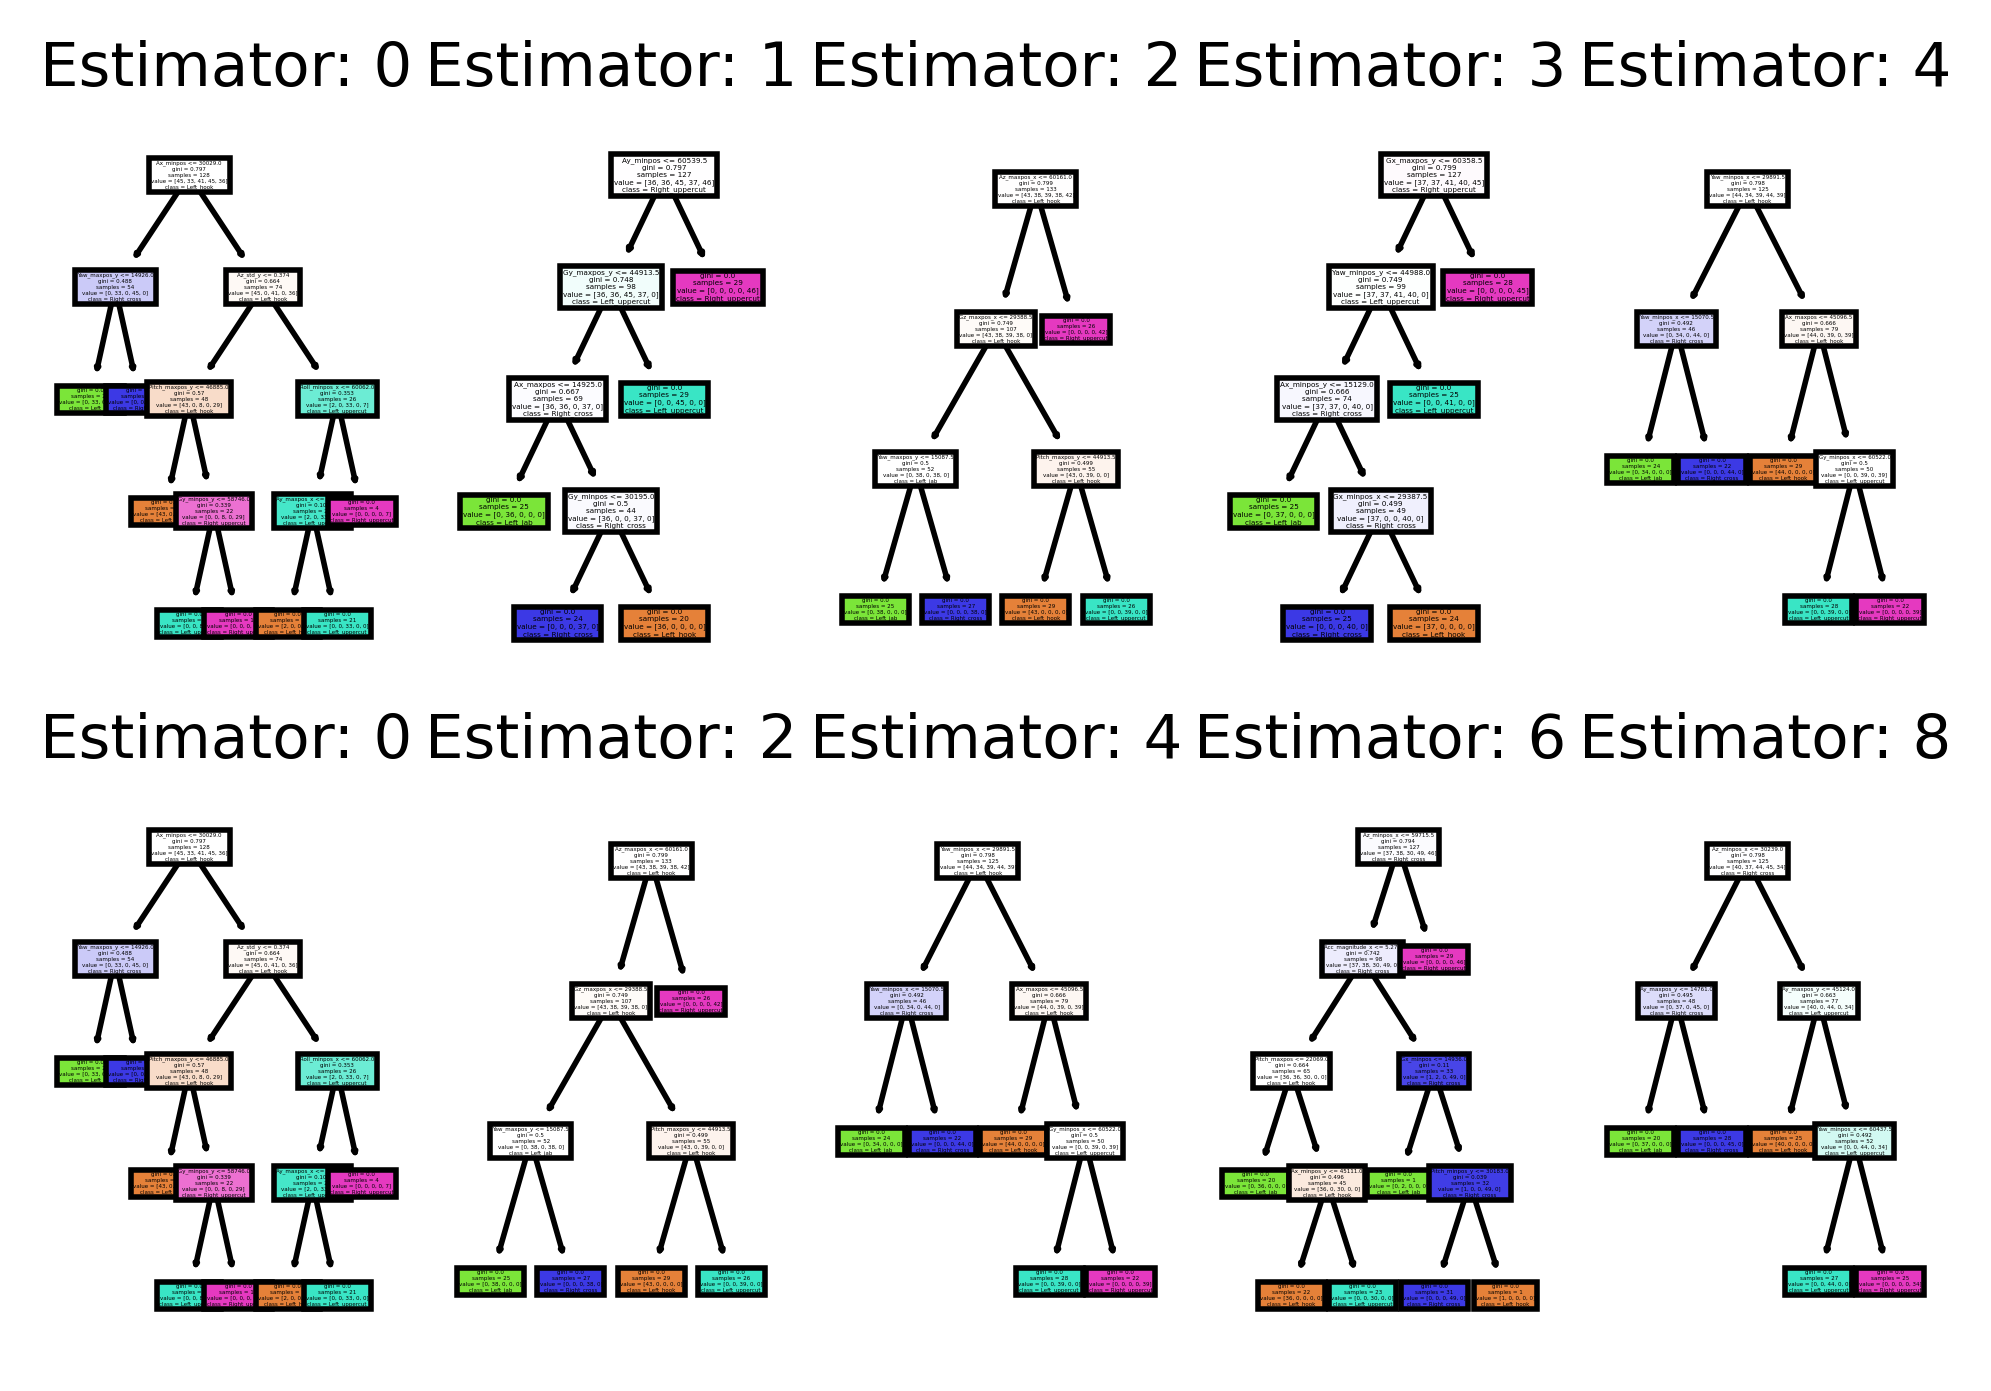

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (6,4), dpi=400)
for index in range(0, 5):
    tree.plot_tree(rf.estimators_[index],feature_names=X_train.columns, class_names=np.unique(y_train.astype(str)),
                    filled = True, ax = axes[0][index]);

    axes[0][index].set_title('Estimator: ' + str(index), fontsize = 11)

for index in range(0,5):
    tree.plot_tree(rf.estimators_[2*index],feature_names=X_train.columns, class_names=np.unique(y_train.astype(str)),
                    filled = True, ax = axes[1][index]);

    axes[1][index].set_title('Estimator: ' + str(2*index), fontsize = 11)

In [ ]:
axes[0][3]

<Axes: title={'center': 'Estimator: 3'}>

#In addition: Multi-layer Perceptron Neural Network

I would try this model as well because the article mentioned this model worked the best for the authors in the classification of punch types

In [ ]:
# different learning rate schedules and momentum parameters
params = [
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0.9,
        "nesterovs_momentum": False,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0.9,
        "nesterovs_momentum": True,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "invscaling",
        "momentum": 0,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "invscaling",
        "momentum": 0.9,
        "nesterovs_momentum": True,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "invscaling",
        "momentum": 0.9,
        "nesterovs_momentum": False,
        "learning_rate_init": 0.2,
    },
    {"solver": "adam", "learning_rate_init": 0.01},
]

labels = [
    "constant learning-rate",
    "constant with momentum",
    "constant with Nesterov's momentum",
    "inv-scaling learning-rate",
    "inv-scaling with momentum",
    "inv-scaling with Nesterov's momentum",
    "adam",
]

plot_args = [
    {"c": "yellow", "linestyle": "-"},
    {"c": "red", "linestyle": "-"},
    {"c": "green", "linestyle": "-"},
    {"c": "blue", "linestyle": "-"},
    {"c": "red", "linestyle": "--"},
    {"c": "green", "linestyle": "--"},
    {"c": "blue", "linestyle": "--"},
    {"c": "black", "linestyle": "-"},
]

X = MinMaxScaler().fit_transform(X_train)

mlps = []
for label, param in zip(labels, params):
    print("training:", label)
    mlp = MLPClassifier(random_state=0, **param)
    mlp.fit(X, y_train)

    mlps.append(mlp)
    print("Training set score:", mlp.score(X, y_train))
    print("Training set loss:", mlp.loss_)

training: constant learning-rate
Training set score: 0.95
Training set loss: 0.11942934587132466
training: constant with momentum
Training set score: 1.0
Training set loss: 0.0071028489819324695
training: constant with Nesterov's momentum
Training set score: 1.0
Training set loss: 0.007300304331158625
training: inv-scaling learning-rate
Training set score: 0.77
Training set loss: 0.8929313111381867
training: inv-scaling with momentum
Training set score: 0.905
Training set loss: 0.3085160792722013
training: inv-scaling with Nesterov's momentum
Training set score: 0.905
Training set loss: 0.3090286641262828
training: adam
Training set score: 1.0
Training set loss: 0.001773491952094899


constant learning-rate
constant with momentum
constant with Nesterov's momentum
inv-scaling learning-rate
inv-scaling with momentum
inv-scaling with Nesterov's momentum
adam


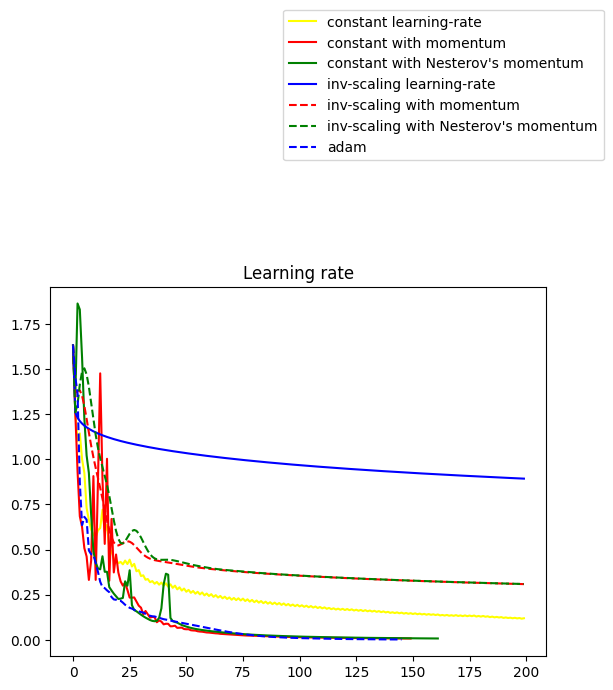

In [ ]:
fig = plt.figure()

for mlp, label, args in zip(mlps, labels, plot_args):
    print(label)
    plt.plot(mlp.loss_curve_, label=label, **args)
fig.legend(labels, loc='center right', bbox_to_anchor=(1, 1.3))
plt.title("Learning rate")
plt.show()

Iteration 1, loss = 1.54474354
Iteration 2, loss = 1.02348310
Iteration 3, loss = 0.82760746
Iteration 4, loss = 1.20508858
Iteration 5, loss = 1.98218022
Iteration 6, loss = 0.87024485
Iteration 7, loss = 0.70538154
Iteration 8, loss = 0.51783474
Iteration 9, loss = 0.46310191
Iteration 10, loss = 0.38678235
Iteration 11, loss = 0.34975609
Iteration 12, loss = 0.32463007
Iteration 13, loss = 0.29955029
Iteration 14, loss = 0.28457615
Iteration 15, loss = 0.26409123
Iteration 16, loss = 0.26877275
Iteration 17, loss = 0.25610685
Iteration 18, loss = 0.33092302
Iteration 19, loss = 0.25189469
Iteration 20, loss = 0.28958941
Iteration 21, loss = 0.18723622
Iteration 22, loss = 0.16851391
Iteration 23, loss = 0.16361873
Iteration 24, loss = 0.15982378
Iteration 25, loss = 0.15511376
Iteration 26, loss = 0.16187073
Iteration 27, loss = 0.16323444
Iteration 28, loss = 0.18560624
Iteration 29, loss = 0.18039504
Iteration 30, loss = 0.19891324
Iteration 31, loss = 0.17065347
Iteration 32, los

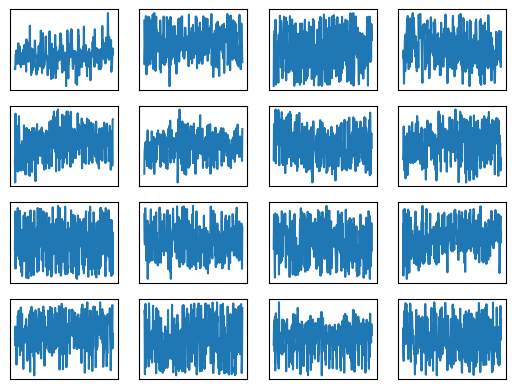

In [ ]:
# hidden layers
mlpNN = MLPClassifier(
    hidden_layer_sizes=(60,),
    alpha=1e-4,
    solver="sgd",
    verbose=10,
    random_state=1,
    learning_rate_init=0.2,
)

X = MinMaxScaler().fit_transform(X_train)

mlpNN.fit(X, y_train)
print("Training set score:", mlpNN.score(X, y_train))
Xt = MinMaxScaler().fit_transform(X_test)
print("Test set score:", mlpNN.score(Xt, y_test))

fig, axes = plt.subplots(4, 4)
for coef, ax in zip(mlpNN.coefs_[0].T, axes.ravel()):
    ax.plot(coef)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

                precision    recall  f1-score   support

     Left_hook       1.00      1.00      1.00        10
      Left_jab       1.00      1.00      1.00        13
 Left_uppercut       1.00      1.00      1.00        11
   Right_cross       1.00      1.00      1.00         7
Right_uppercut       1.00      1.00      1.00         9

      accuracy                           1.00        50
     macro avg       1.00      1.00      1.00        50
  weighted avg       1.00      1.00      1.00        50



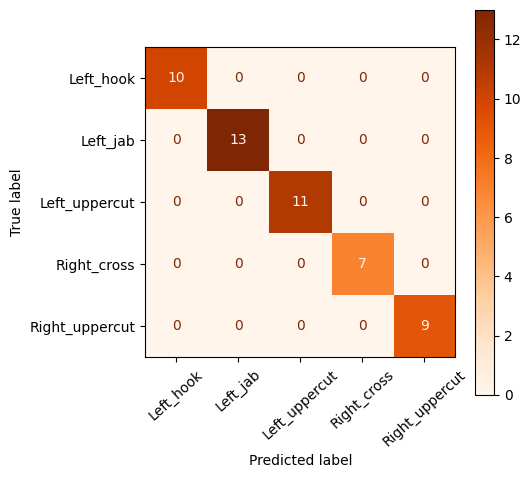

In [ ]:
mlp_pred = mlpNN.predict(Xt)
print(classification_report(y_test, mlp_pred))

matrix2 = ConfusionMatrixDisplay.from_estimator(
        mlpNN,
        Xt,
        y_test,
        cmap=plt.cm.Oranges,
        xticks_rotation=42
    )
matrix2.figure_.set_size_inches(5,5)

As in the article, multi-layer perceptron neural network is really the best model to classify punch types in box